In [1]:
# IMPORTS
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

from scipy.misc import toimage

from scipy import sparse
import scipy

from random import randrange

import tensorflow as tf

import time
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#LOAD MODEL
model_fn = './inception5h/tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [3]:
#GET LAYERS, CHANNELS
layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
filtered_layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and ('import/' and
                        ("5x5" or "3x3" or "5x5"  or "conv2d") in op.name) and "bottleneck" not in op.name]

feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layer_names]

print(filtered_layer_names)

layers = []
channels = []
target_activations = []
layer_indexes = []

global_channel_idx =0

for idx, layer_name in enumerate(layer_names):
    layer_name = str(layer_name[:-5] + ":0") #remove the "/conv" part, and add ":0"
    print(layer_name)
    layers.append(graph.get_tensor_by_name(layer_name))
    print(layers[idx].shape[3])
    
    #store the channel indexes of a layer
    layer_indexes.append(np.arange(global_channel_idx,global_channel_idx + int(layers[idx].shape[3])))
    global_channel_idx = global_channel_idx + int(layers[idx].shape[3])
    
    for channel_idx in range(0,layers[idx].shape[3]):
        channel = layers[idx][:,:,:,channel_idx]
        channels.append(channel)
        target_activations.append(tf.reduce_mean(channel))

[u'import/mixed3a_5x5_pre_relu/conv', u'import/mixed3b_5x5_pre_relu/conv', u'import/mixed4a_5x5_pre_relu/conv', u'import/mixed4b_5x5_pre_relu/conv', u'import/mixed4c_5x5_pre_relu/conv', u'import/mixed4d_5x5_pre_relu/conv', u'import/mixed4e_5x5_pre_relu/conv', u'import/mixed5a_5x5_pre_relu/conv', u'import/mixed5b_5x5_pre_relu/conv']
import/conv2d0_pre_relu:0
64
import/conv2d1_pre_relu:0
64
import/conv2d2_pre_relu:0
192
import/mixed3a_1x1_pre_relu:0
64
import/mixed3a_3x3_bottleneck_pre_relu:0
96
import/mixed3a_3x3_pre_relu:0
128
import/mixed3a_5x5_bottleneck_pre_relu:0
16
import/mixed3a_5x5_pre_relu:0
32
import/mixed3a_pool_reduce_pre_relu:0
32
import/mixed3b_1x1_pre_relu:0
128
import/mixed3b_3x3_bottleneck_pre_relu:0
128
import/mixed3b_3x3_pre_relu:0
192
import/mixed3b_5x5_bottleneck_pre_relu:0
32
import/mixed3b_5x5_pre_relu:0
96
import/mixed3b_pool_reduce_pre_relu:0
64
import/mixed4a_1x1_pre_relu:0
192
import/mixed4a_3x3_bottleneck_pre_relu:0
96
import/mixed4a_3x3_pre_relu:0
204
import

In [4]:
#CONSTANTS
nbr_samples = 50000
nbr_classes = 1000
nbr_channels = len(channels)

In [3]:
layer_names = [op.name for op in graph.get_operations()]
layer_types = [op.type for op in graph.get_operations()]

for i in range(0,len(layer_names)):
    print("layer name: " + layer_names[i] + " layer type: " + str(layer_types[i]))


layer name: input layer type: Placeholder
layer name: sub/y layer type: Const
layer name: sub layer type: Sub
layer name: ExpandDims/dim layer type: Const
layer name: ExpandDims layer type: ExpandDims
layer name: import/input layer type: Placeholder
layer name: import/conv2d0_w layer type: Const
layer name: import/conv2d0_b layer type: Const
layer name: import/conv2d1_w layer type: Const
layer name: import/conv2d1_b layer type: Const
layer name: import/conv2d2_w layer type: Const
layer name: import/conv2d2_b layer type: Const
layer name: import/mixed3a_1x1_w layer type: Const
layer name: import/mixed3a_1x1_b layer type: Const
layer name: import/mixed3a_3x3_bottleneck_w layer type: Const
layer name: import/mixed3a_3x3_bottleneck_b layer type: Const
layer name: import/mixed3a_3x3_w layer type: Const
layer name: import/mixed3a_3x3_b layer type: Const
layer name: import/mixed3a_5x5_bottleneck_w layer type: Const
layer name: import/mixed3a_5x5_bottleneck_b layer type: Const
layer name: impo

In [134]:
# TEST - GET PREDICTION

layer_names = [op.name for op in graph.get_operations() if op.type=='Softmax' and 'import/' in op.name]
#layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]

layer_name = layer_names[0]
layer_name = "import/output2"

print(layer_name)
#layer_name = str(layer_name[:-5] + ":0") #remove the "/conv" part, and add ":0"
layer_name = str(layer_name + ":0") #remove the "/conv" part, and add ":0"
print(layer_name)
tensor = graph.get_tensor_by_name(layer_name)
print(tensor)

target_activations = tensor

#img = np.random.uniform(size=(224,224,3)) + 100.0
img = load_image("/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/ILSVRC2012_val_00050000.JPEG")
activations = sess.run(target_activations, {t_input:img})
activations

import/output2
import/output2:0
Tensor("import/output2:0", shape=(?, 1008), dtype=float32, device=/device:CPU:0)


array([[2.6063701e-05, 5.5567518e-05, 1.4288889e-04, ..., 2.6061787e-05,
        2.6064819e-05, 2.6063553e-05],
       [1.1787291e-05, 7.5461510e-05, 1.5134634e-04, ..., 1.1786415e-05,
        1.1787774e-05, 1.1787212e-05],
       [3.8253575e-06, 6.7313777e-05, 9.6792537e-05, ..., 3.8250728e-06,
        3.8255180e-06, 3.8253356e-06],
       ...,
       [1.0512800e-09, 1.0109955e-07, 1.2947408e-08, ..., 1.0512037e-09,
        1.0513261e-09, 1.0512740e-09],
       [1.3573810e-09, 6.8309078e-08, 1.8532976e-08, ..., 1.3572825e-09,
        1.3574404e-09, 1.3573731e-09],
       [1.0328166e-08, 2.0909830e-07, 1.7736924e-07, ..., 1.0327398e-08,
        1.0328599e-08, 1.0328107e-08]], dtype=float32)

In [5]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [6]:
def convert2time(time_sec):
    sec = time_sec%60
    minute = (time_sec/60)%60
    hour = (time_sec/3600)%60
    
    return str(hour) + ":" + str(minute) + ":" + str(sec)

In [15]:
import IPython.display

img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

filename = "ILSVRC2012_val_00000034.JPEG"

img = load_image(os.path.join(img_dir,filename))
print(img.shape)
b = np.repeat(img[:, :, np.newaxis], 3, axis=2)

IPython.display(PIL.Image.fromarray(img))


(363, 500)


TypeError: 'module' object is not callable

In [10]:
#GET ACTIVATIONS

saveFrequency = 100

#img_dir = os.path.join( "E:", "PPKE", "Diplomamunka","adatbazisok","ImageNet","ILSVRC2012_img_val")
img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

all_activation = np.zeros((nbr_samples,nbr_channels))


for img_idx,filename in enumerate(sorted(os.listdir(img_dir))):
    start = time.time()
    img = load_image(os.path.join(img_dir,filename))
    if len(img.shape)!=3: # if not a color image
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    
    try:
        activations = sess.run(target_activations, {t_input:img})
        all_activation[img_idx,:] = activations
    except:
        print("\n Processing error with image " + str(filename) + "\n")
    
    end = time.time()
    remaningTime = convert2time(int((end - start)*(nbr_samples-img_idx)))
    
    print("Image: " + str(img_idx+1) + "/" + str(nbr_samples) + "   Remaning time: " +  remaningTime,end="\r")

    if (img_idx%saveFrequency)==saveFrequency-1:
        np.savetxt("./activations2/" +str(img_idx) + ".txt", all_activation[img_idx-saveFrequency+1:img_idx+1,:], delimiter=',')
    

Image: 19876/50000   Remaning time: 3:52:323
 Processing error with image ILSVRC2012_val_00019877.JPEG

Image: 48408/50000   Remaning time: 0:11:315
 Processing error with image ILSVRC2012_val_00048409.JPEG



In [119]:
#GET PREDICTIONS


img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"
all_predictions = np.zeros((nbr_samples))

layer_names = [op.name for op in graph.get_operations() if op.type=='Softmax' and 'import/' in op.name]

layer_name = layer_names[2] #3rd softmax layer
print(layer_name)
layer_name = str(layer_name + ":0")
print(layer_name)
tensor = graph.get_tensor_by_name(layer_name)
print(tensor)

target_activations = tensor

img_idx=0

for filename in sorted(os.listdir(img_dir)):  
    
    img_noise = np.random.uniform(size=(224,224,3)) + 100.0
    img = load_image(os.path.join(img_dir,filename))
    print(img.shape)

    if len(img.shape)!=3: # if not a color image
        img_idx +=1
        continue
    
    start = time.time()
    activations = sess.run(target_activations, {t_input:img_noise})
    end = time.time()
    print("sess run: " + str(end - start))
    print(activations.shape)
    for i in range(0,80):
        print(str(sum(activations[i,:])))
    print(str(activations))
    
    #all_predictions[img_idx] = activations
    plt.plot(np.matrix.transpose(activations))
    img_idx +=1
    input("kaja")

import/softmax2
import/softmax2:0
Tensor("import/softmax2:0", shape=(?, 1008), dtype=float32, device=/device:CPU:0)
(500, 420, 3)
sess run: 0.0299510955811
(1, 1008)
1.0000000853909796


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
#LOAD ACTIVATION ARRAYS
import numpy as np


saveFrequency = 100

all_activation = np.zeros((nbr_samples,nbr_channels))

for idx, activationTxt in enumerate(os.listdir("./activations2/")):
    print("Activations loaded: " + str((idx+1)*saveFrequency) + "/" + str(nbr_samples),end="\r")
    endIndex = int(activationTxt.split('.')[0])
    all_activation[endIndex-saveFrequency+1:endIndex+1,:] = np.loadtxt("./activations2/" + activationTxt,delimiter=',')

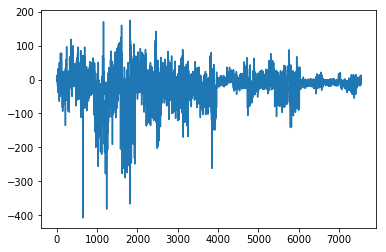

In [8]:
plt.plot(all_activation[40900,:])

In [ ]:
all_activation_original = np.copy(all_activation)

In [ ]:
#LOAD GROUND TRUTH LABELS and the class names

############ THE GROUND TRUTH VALUES ARE BETWEEN 1 AND 1000 !!! ##################
grountTruth = np.loadtxt('ILSVRC2012_validation_ground_truth.txt')
print(grountTruth.shape)

with open('inception5h/imagenet_comp_graph_label_strings.txt') as f:
    classNames = f.read().splitlines() 

In [95]:
#GET FIRST X MAXIMUM ACTIVATIONS OF EVERY CHANNELS
import matplotlib.pyplot as plt

nbr_classes = 1000
nbrMaxActivations = 100


topActivationsOfChannels = np.zeros((all_activation.shape[1],nbr_classes))
mostActivations = np.zeros((all_activation.shape[1]))

for channelNbr in range(0,all_activation.shape[1]):
    #activatioons of a particular channel
    channelActivations = all_activation[:,channelNbr]
    #top nbrMaxActivations activations of a particular channel
    maxActivations = np.sort(channelActivations)[-nbrMaxActivations:]
    #image indexes of the top nbrMaxActivations activations of a particular channel
    maxActivationIndexes = np.argsort(channelActivations)[-nbrMaxActivations:]
    
    #classes of the top nbrMaxActivations activations of a particular channel
    maxActivationClasses = grountTruth[maxActivationIndexes]
    
    for activationIdx in range(0,nbrMaxActivations):
        #get class index of an activation
        classIdx = int(maxActivationClasses[activationIdx])
        #get the size of an activation
        activation = maxActivations[activationIdx]
        #store the weighted class activation
        topActivationsOfChannels[channelNbr,classIdx-1] += activation
    
    
    classActivations,bins = np.histogram(maxActivationClasses,bins=nbr_classes)
    print("Channel number: " + str(channelNbr) + " Most activation in class: " + str(max(classActivations)))
    
    mostActivations[channelNbr] = max(classActivations)        

Channel number: 0 Most activation in class: 4
Channel number: 1 Most activation in class: 6
Channel number: 2 Most activation in class: 6
Channel number: 3 Most activation in class: 23
Channel number: 4 Most activation in class: 5
Channel number: 5 Most activation in class: 7
Channel number: 6 Most activation in class: 12
Channel number: 7 Most activation in class: 4
Channel number: 8 Most activation in class: 23
Channel number: 9 Most activation in class: 5
Channel number: 10 Most activation in class: 18
Channel number: 11 Most activation in class: 3
Channel number: 12 Most activation in class: 5
Channel number: 13 Most activation in class: 10
Channel number: 14 Most activation in class: 15
Channel number: 15 Most activation in class: 4
Channel number: 16 Most activation in class: 8
Channel number: 17 Most activation in class: 7
Channel number: 18 Most activation in class: 8
Channel number: 19 Most activation in class: 6
Channel number: 20 Most activation in class: 8
Channel number: 2

Channel number: 191 Most activation in class: 3
Channel number: 192 Most activation in class: 8
Channel number: 193 Most activation in class: 4
Channel number: 194 Most activation in class: 4
Channel number: 195 Most activation in class: 7
Channel number: 196 Most activation in class: 7
Channel number: 197 Most activation in class: 3
Channel number: 198 Most activation in class: 6
Channel number: 199 Most activation in class: 5
Channel number: 200 Most activation in class: 13
Channel number: 201 Most activation in class: 3
Channel number: 202 Most activation in class: 3
Channel number: 203 Most activation in class: 9
Channel number: 204 Most activation in class: 8
Channel number: 205 Most activation in class: 5
Channel number: 206 Most activation in class: 10
Channel number: 207 Most activation in class: 8
Channel number: 208 Most activation in class: 10
Channel number: 209 Most activation in class: 5
Channel number: 210 Most activation in class: 4
Channel number: 211 Most activation i

Channel number: 368 Most activation in class: 6
Channel number: 369 Most activation in class: 3
Channel number: 370 Most activation in class: 3
Channel number: 371 Most activation in class: 6
Channel number: 372 Most activation in class: 3
Channel number: 373 Most activation in class: 9
Channel number: 374 Most activation in class: 3
Channel number: 375 Most activation in class: 7
Channel number: 376 Most activation in class: 6
Channel number: 377 Most activation in class: 4
Channel number: 378 Most activation in class: 8
Channel number: 379 Most activation in class: 3
Channel number: 380 Most activation in class: 4
Channel number: 381 Most activation in class: 5
Channel number: 382 Most activation in class: 19
Channel number: 383 Most activation in class: 2
Channel number: 384 Most activation in class: 4
Channel number: 385 Most activation in class: 4
Channel number: 386 Most activation in class: 8
Channel number: 387 Most activation in class: 4
Channel number: 388 Most activation in 

Channel number: 538 Most activation in class: 7
Channel number: 539 Most activation in class: 5
Channel number: 540 Most activation in class: 8
Channel number: 541 Most activation in class: 3
Channel number: 542 Most activation in class: 10
Channel number: 543 Most activation in class: 8
Channel number: 544 Most activation in class: 8
Channel number: 545 Most activation in class: 4
Channel number: 546 Most activation in class: 4
Channel number: 547 Most activation in class: 7
Channel number: 548 Most activation in class: 5
Channel number: 549 Most activation in class: 4
Channel number: 550 Most activation in class: 3
Channel number: 551 Most activation in class: 5
Channel number: 552 Most activation in class: 3
Channel number: 553 Most activation in class: 15
Channel number: 554 Most activation in class: 3
Channel number: 555 Most activation in class: 4
Channel number: 556 Most activation in class: 4
Channel number: 557 Most activation in class: 15
Channel number: 558 Most activation i

Channel number: 732 Most activation in class: 4
Channel number: 733 Most activation in class: 3
Channel number: 734 Most activation in class: 3
Channel number: 735 Most activation in class: 10
Channel number: 736 Most activation in class: 6
Channel number: 737 Most activation in class: 4
Channel number: 738 Most activation in class: 7
Channel number: 739 Most activation in class: 5
Channel number: 740 Most activation in class: 3
Channel number: 741 Most activation in class: 4
Channel number: 742 Most activation in class: 8
Channel number: 743 Most activation in class: 4
Channel number: 744 Most activation in class: 5
Channel number: 745 Most activation in class: 3
Channel number: 746 Most activation in class: 6
Channel number: 747 Most activation in class: 3
Channel number: 748 Most activation in class: 5
Channel number: 749 Most activation in class: 11
Channel number: 750 Most activation in class: 5
Channel number: 751 Most activation in class: 11
Channel number: 752 Most activation i

Channel number: 912 Most activation in class: 3
Channel number: 913 Most activation in class: 4
Channel number: 914 Most activation in class: 6
Channel number: 915 Most activation in class: 8
Channel number: 916 Most activation in class: 6
Channel number: 917 Most activation in class: 9
Channel number: 918 Most activation in class: 4
Channel number: 919 Most activation in class: 5
Channel number: 920 Most activation in class: 3
Channel number: 921 Most activation in class: 5
Channel number: 922 Most activation in class: 6
Channel number: 923 Most activation in class: 7
Channel number: 924 Most activation in class: 8
Channel number: 925 Most activation in class: 13
Channel number: 926 Most activation in class: 9
Channel number: 927 Most activation in class: 9
Channel number: 928 Most activation in class: 10
Channel number: 929 Most activation in class: 6
Channel number: 930 Most activation in class: 5
Channel number: 931 Most activation in class: 12
Channel number: 932 Most activation i

Channel number: 1084 Most activation in class: 10
Channel number: 1085 Most activation in class: 10
Channel number: 1086 Most activation in class: 10
Channel number: 1087 Most activation in class: 4
Channel number: 1088 Most activation in class: 6
Channel number: 1089 Most activation in class: 3
Channel number: 1090 Most activation in class: 3
Channel number: 1091 Most activation in class: 9
Channel number: 1092 Most activation in class: 19
Channel number: 1093 Most activation in class: 6
Channel number: 1094 Most activation in class: 4
Channel number: 1095 Most activation in class: 4
Channel number: 1096 Most activation in class: 5
Channel number: 1097 Most activation in class: 4
Channel number: 1098 Most activation in class: 4
Channel number: 1099 Most activation in class: 6
Channel number: 1100 Most activation in class: 7
Channel number: 1101 Most activation in class: 4
Channel number: 1102 Most activation in class: 9
Channel number: 1103 Most activation in class: 11
Channel number:

Channel number: 1256 Most activation in class: 21
Channel number: 1257 Most activation in class: 5
Channel number: 1258 Most activation in class: 10
Channel number: 1259 Most activation in class: 10
Channel number: 1260 Most activation in class: 8
Channel number: 1261 Most activation in class: 6
Channel number: 1262 Most activation in class: 3
Channel number: 1263 Most activation in class: 3
Channel number: 1264 Most activation in class: 3
Channel number: 1265 Most activation in class: 5
Channel number: 1266 Most activation in class: 7
Channel number: 1267 Most activation in class: 10
Channel number: 1268 Most activation in class: 5
Channel number: 1269 Most activation in class: 9
Channel number: 1270 Most activation in class: 5
Channel number: 1271 Most activation in class: 3
Channel number: 1272 Most activation in class: 4
Channel number: 1273 Most activation in class: 3
Channel number: 1274 Most activation in class: 5
Channel number: 1275 Most activation in class: 8
Channel number: 

Channel number: 1427 Most activation in class: 9
Channel number: 1428 Most activation in class: 5
Channel number: 1429 Most activation in class: 6
Channel number: 1430 Most activation in class: 10
Channel number: 1431 Most activation in class: 4
Channel number: 1432 Most activation in class: 5
Channel number: 1433 Most activation in class: 5
Channel number: 1434 Most activation in class: 5
Channel number: 1435 Most activation in class: 14
Channel number: 1436 Most activation in class: 4
Channel number: 1437 Most activation in class: 11
Channel number: 1438 Most activation in class: 13
Channel number: 1439 Most activation in class: 6
Channel number: 1440 Most activation in class: 4
Channel number: 1441 Most activation in class: 6
Channel number: 1442 Most activation in class: 3
Channel number: 1443 Most activation in class: 4
Channel number: 1444 Most activation in class: 6
Channel number: 1445 Most activation in class: 3
Channel number: 1446 Most activation in class: 9
Channel number: 

Channel number: 1617 Most activation in class: 3
Channel number: 1618 Most activation in class: 11
Channel number: 1619 Most activation in class: 5
Channel number: 1620 Most activation in class: 9
Channel number: 1621 Most activation in class: 7
Channel number: 1622 Most activation in class: 10
Channel number: 1623 Most activation in class: 3
Channel number: 1624 Most activation in class: 3
Channel number: 1625 Most activation in class: 13
Channel number: 1626 Most activation in class: 17
Channel number: 1627 Most activation in class: 9
Channel number: 1628 Most activation in class: 8
Channel number: 1629 Most activation in class: 5
Channel number: 1630 Most activation in class: 4
Channel number: 1631 Most activation in class: 3
Channel number: 1632 Most activation in class: 20
Channel number: 1633 Most activation in class: 3
Channel number: 1634 Most activation in class: 8
Channel number: 1635 Most activation in class: 8
Channel number: 1636 Most activation in class: 5
Channel number:

Channel number: 1793 Most activation in class: 5
Channel number: 1794 Most activation in class: 8
Channel number: 1795 Most activation in class: 3
Channel number: 1796 Most activation in class: 6
Channel number: 1797 Most activation in class: 5
Channel number: 1798 Most activation in class: 5
Channel number: 1799 Most activation in class: 5
Channel number: 1800 Most activation in class: 5
Channel number: 1801 Most activation in class: 7
Channel number: 1802 Most activation in class: 10
Channel number: 1803 Most activation in class: 9
Channel number: 1804 Most activation in class: 9
Channel number: 1805 Most activation in class: 6
Channel number: 1806 Most activation in class: 7
Channel number: 1807 Most activation in class: 7
Channel number: 1808 Most activation in class: 5
Channel number: 1809 Most activation in class: 7
Channel number: 1810 Most activation in class: 5
Channel number: 1811 Most activation in class: 12
Channel number: 1812 Most activation in class: 5
Channel number: 18

Channel number: 1967 Most activation in class: 16
Channel number: 1968 Most activation in class: 7
Channel number: 1969 Most activation in class: 5
Channel number: 1970 Most activation in class: 6
Channel number: 1971 Most activation in class: 12
Channel number: 1972 Most activation in class: 14
Channel number: 1973 Most activation in class: 9
Channel number: 1974 Most activation in class: 6
Channel number: 1975 Most activation in class: 7
Channel number: 1976 Most activation in class: 13
Channel number: 1977 Most activation in class: 12
Channel number: 1978 Most activation in class: 6
Channel number: 1979 Most activation in class: 11
Channel number: 1980 Most activation in class: 4
Channel number: 1981 Most activation in class: 4
Channel number: 1982 Most activation in class: 5
Channel number: 1983 Most activation in class: 8
Channel number: 1984 Most activation in class: 5
Channel number: 1985 Most activation in class: 4
Channel number: 1986 Most activation in class: 5
Channel number

Channel number: 2143 Most activation in class: 6
Channel number: 2144 Most activation in class: 7
Channel number: 2145 Most activation in class: 9
Channel number: 2146 Most activation in class: 5
Channel number: 2147 Most activation in class: 24
Channel number: 2148 Most activation in class: 11
Channel number: 2149 Most activation in class: 10
Channel number: 2150 Most activation in class: 6
Channel number: 2151 Most activation in class: 16
Channel number: 2152 Most activation in class: 8
Channel number: 2153 Most activation in class: 6
Channel number: 2154 Most activation in class: 6
Channel number: 2155 Most activation in class: 10
Channel number: 2156 Most activation in class: 4
Channel number: 2157 Most activation in class: 9
Channel number: 2158 Most activation in class: 10
Channel number: 2159 Most activation in class: 8
Channel number: 2160 Most activation in class: 5
Channel number: 2161 Most activation in class: 6
Channel number: 2162 Most activation in class: 9
Channel number

Channel number: 2320 Most activation in class: 10
Channel number: 2321 Most activation in class: 7
Channel number: 2322 Most activation in class: 9
Channel number: 2323 Most activation in class: 6
Channel number: 2324 Most activation in class: 12
Channel number: 2325 Most activation in class: 4
Channel number: 2326 Most activation in class: 10
Channel number: 2327 Most activation in class: 16
Channel number: 2328 Most activation in class: 12
Channel number: 2329 Most activation in class: 20
Channel number: 2330 Most activation in class: 20
Channel number: 2331 Most activation in class: 15
Channel number: 2332 Most activation in class: 6
Channel number: 2333 Most activation in class: 7
Channel number: 2334 Most activation in class: 6
Channel number: 2335 Most activation in class: 6
Channel number: 2336 Most activation in class: 10
Channel number: 2337 Most activation in class: 8
Channel number: 2338 Most activation in class: 5
Channel number: 2339 Most activation in class: 12
Channel nu

Channel number: 2497 Most activation in class: 6
Channel number: 2498 Most activation in class: 3
Channel number: 2499 Most activation in class: 4
Channel number: 2500 Most activation in class: 4
Channel number: 2501 Most activation in class: 5
Channel number: 2502 Most activation in class: 9
Channel number: 2503 Most activation in class: 5
Channel number: 2504 Most activation in class: 19
Channel number: 2505 Most activation in class: 6
Channel number: 2506 Most activation in class: 4
Channel number: 2507 Most activation in class: 4
Channel number: 2508 Most activation in class: 7
Channel number: 2509 Most activation in class: 3
Channel number: 2510 Most activation in class: 5
Channel number: 2511 Most activation in class: 20
Channel number: 2512 Most activation in class: 5
Channel number: 2513 Most activation in class: 5
Channel number: 2514 Most activation in class: 4
Channel number: 2515 Most activation in class: 3
Channel number: 2516 Most activation in class: 5
Channel number: 25

Channel number: 2675 Most activation in class: 17
Channel number: 2676 Most activation in class: 6
Channel number: 2677 Most activation in class: 7
Channel number: 2678 Most activation in class: 7
Channel number: 2679 Most activation in class: 9
Channel number: 2680 Most activation in class: 10
Channel number: 2681 Most activation in class: 11
Channel number: 2682 Most activation in class: 8
Channel number: 2683 Most activation in class: 22
Channel number: 2684 Most activation in class: 9
Channel number: 2685 Most activation in class: 4
Channel number: 2686 Most activation in class: 3
Channel number: 2687 Most activation in class: 6
Channel number: 2688 Most activation in class: 12
Channel number: 2689 Most activation in class: 10
Channel number: 2690 Most activation in class: 22
Channel number: 2691 Most activation in class: 7
Channel number: 2692 Most activation in class: 6
Channel number: 2693 Most activation in class: 9
Channel number: 2694 Most activation in class: 5
Channel numbe

Channel number: 2854 Most activation in class: 8
Channel number: 2855 Most activation in class: 11
Channel number: 2856 Most activation in class: 13
Channel number: 2857 Most activation in class: 15
Channel number: 2858 Most activation in class: 8
Channel number: 2859 Most activation in class: 9
Channel number: 2860 Most activation in class: 4
Channel number: 2861 Most activation in class: 9
Channel number: 2862 Most activation in class: 16
Channel number: 2863 Most activation in class: 6
Channel number: 2864 Most activation in class: 12
Channel number: 2865 Most activation in class: 10
Channel number: 2866 Most activation in class: 8
Channel number: 2867 Most activation in class: 15
Channel number: 2868 Most activation in class: 7
Channel number: 2869 Most activation in class: 6
Channel number: 2870 Most activation in class: 8
Channel number: 2871 Most activation in class: 13
Channel number: 2872 Most activation in class: 8
Channel number: 2873 Most activation in class: 5
Channel numb

Channel number: 3030 Most activation in class: 6
Channel number: 3031 Most activation in class: 14
Channel number: 3032 Most activation in class: 11
Channel number: 3033 Most activation in class: 11
Channel number: 3034 Most activation in class: 11
Channel number: 3035 Most activation in class: 21
Channel number: 3036 Most activation in class: 16
Channel number: 3037 Most activation in class: 15
Channel number: 3038 Most activation in class: 7
Channel number: 3039 Most activation in class: 7
Channel number: 3040 Most activation in class: 7
Channel number: 3041 Most activation in class: 5
Channel number: 3042 Most activation in class: 20
Channel number: 3043 Most activation in class: 20
Channel number: 3044 Most activation in class: 11
Channel number: 3045 Most activation in class: 5
Channel number: 3046 Most activation in class: 9
Channel number: 3047 Most activation in class: 10
Channel number: 3048 Most activation in class: 6
Channel number: 3049 Most activation in class: 6
Channel n

Channel number: 3209 Most activation in class: 10
Channel number: 3210 Most activation in class: 11
Channel number: 3211 Most activation in class: 12
Channel number: 3212 Most activation in class: 6
Channel number: 3213 Most activation in class: 6
Channel number: 3214 Most activation in class: 12
Channel number: 3215 Most activation in class: 39
Channel number: 3216 Most activation in class: 12
Channel number: 3217 Most activation in class: 13
Channel number: 3218 Most activation in class: 8
Channel number: 3219 Most activation in class: 9
Channel number: 3220 Most activation in class: 11
Channel number: 3221 Most activation in class: 8
Channel number: 3222 Most activation in class: 10
Channel number: 3223 Most activation in class: 8
Channel number: 3224 Most activation in class: 17
Channel number: 3225 Most activation in class: 12
Channel number: 3226 Most activation in class: 8
Channel number: 3227 Most activation in class: 11
Channel number: 3228 Most activation in class: 17
Channel

Channel number: 3388 Most activation in class: 6
Channel number: 3389 Most activation in class: 15
Channel number: 3390 Most activation in class: 6
Channel number: 3391 Most activation in class: 9
Channel number: 3392 Most activation in class: 6
Channel number: 3393 Most activation in class: 4
Channel number: 3394 Most activation in class: 24
Channel number: 3395 Most activation in class: 7
Channel number: 3396 Most activation in class: 18
Channel number: 3397 Most activation in class: 12
Channel number: 3398 Most activation in class: 16
Channel number: 3399 Most activation in class: 13
Channel number: 3400 Most activation in class: 11
Channel number: 3401 Most activation in class: 7
Channel number: 3402 Most activation in class: 10
Channel number: 3403 Most activation in class: 16
Channel number: 3404 Most activation in class: 7
Channel number: 3405 Most activation in class: 10
Channel number: 3406 Most activation in class: 13
Channel number: 3407 Most activation in class: 8
Channel n

Channel number: 3563 Most activation in class: 20
Channel number: 3564 Most activation in class: 7
Channel number: 3565 Most activation in class: 9
Channel number: 3566 Most activation in class: 8
Channel number: 3567 Most activation in class: 19
Channel number: 3568 Most activation in class: 14
Channel number: 3569 Most activation in class: 12
Channel number: 3570 Most activation in class: 8
Channel number: 3571 Most activation in class: 9
Channel number: 3572 Most activation in class: 14
Channel number: 3573 Most activation in class: 9
Channel number: 3574 Most activation in class: 9
Channel number: 3575 Most activation in class: 7
Channel number: 3576 Most activation in class: 18
Channel number: 3577 Most activation in class: 13
Channel number: 3578 Most activation in class: 7
Channel number: 3579 Most activation in class: 8
Channel number: 3580 Most activation in class: 8
Channel number: 3581 Most activation in class: 8
Channel number: 3582 Most activation in class: 7
Channel numbe

Channel number: 3740 Most activation in class: 5
Channel number: 3741 Most activation in class: 15
Channel number: 3742 Most activation in class: 9
Channel number: 3743 Most activation in class: 9
Channel number: 3744 Most activation in class: 11
Channel number: 3745 Most activation in class: 13
Channel number: 3746 Most activation in class: 16
Channel number: 3747 Most activation in class: 9
Channel number: 3748 Most activation in class: 11
Channel number: 3749 Most activation in class: 14
Channel number: 3750 Most activation in class: 6
Channel number: 3751 Most activation in class: 7
Channel number: 3752 Most activation in class: 9
Channel number: 3753 Most activation in class: 6
Channel number: 3754 Most activation in class: 14
Channel number: 3755 Most activation in class: 6
Channel number: 3756 Most activation in class: 11
Channel number: 3757 Most activation in class: 6
Channel number: 3758 Most activation in class: 6
Channel number: 3759 Most activation in class: 5
Channel numb

Channel number: 3919 Most activation in class: 12
Channel number: 3920 Most activation in class: 26
Channel number: 3921 Most activation in class: 16
Channel number: 3922 Most activation in class: 6
Channel number: 3923 Most activation in class: 13
Channel number: 3924 Most activation in class: 13
Channel number: 3925 Most activation in class: 11
Channel number: 3926 Most activation in class: 5
Channel number: 3927 Most activation in class: 14
Channel number: 3928 Most activation in class: 11
Channel number: 3929 Most activation in class: 10
Channel number: 3930 Most activation in class: 11
Channel number: 3931 Most activation in class: 12
Channel number: 3932 Most activation in class: 8
Channel number: 3933 Most activation in class: 18
Channel number: 3934 Most activation in class: 14
Channel number: 3935 Most activation in class: 11
Channel number: 3936 Most activation in class: 11
Channel number: 3937 Most activation in class: 20
Channel number: 3938 Most activation in class: 38
Cha

Channel number: 4095 Most activation in class: 10
Channel number: 4096 Most activation in class: 8
Channel number: 4097 Most activation in class: 8
Channel number: 4098 Most activation in class: 9
Channel number: 4099 Most activation in class: 9
Channel number: 4100 Most activation in class: 9
Channel number: 4101 Most activation in class: 7
Channel number: 4102 Most activation in class: 18
Channel number: 4103 Most activation in class: 24
Channel number: 4104 Most activation in class: 12
Channel number: 4105 Most activation in class: 6
Channel number: 4106 Most activation in class: 10
Channel number: 4107 Most activation in class: 12
Channel number: 4108 Most activation in class: 11
Channel number: 4109 Most activation in class: 15
Channel number: 4110 Most activation in class: 5
Channel number: 4111 Most activation in class: 9
Channel number: 4112 Most activation in class: 15
Channel number: 4113 Most activation in class: 12
Channel number: 4114 Most activation in class: 14
Channel n

Channel number: 4273 Most activation in class: 6
Channel number: 4274 Most activation in class: 17
Channel number: 4275 Most activation in class: 7
Channel number: 4276 Most activation in class: 11
Channel number: 4277 Most activation in class: 7
Channel number: 4278 Most activation in class: 9
Channel number: 4279 Most activation in class: 17
Channel number: 4280 Most activation in class: 17
Channel number: 4281 Most activation in class: 5
Channel number: 4282 Most activation in class: 13
Channel number: 4283 Most activation in class: 9
Channel number: 4284 Most activation in class: 6
Channel number: 4285 Most activation in class: 10
Channel number: 4286 Most activation in class: 19
Channel number: 4287 Most activation in class: 11
Channel number: 4288 Most activation in class: 26
Channel number: 4289 Most activation in class: 8
Channel number: 4290 Most activation in class: 6
Channel number: 4291 Most activation in class: 12
Channel number: 4292 Most activation in class: 6
Channel nu

Channel number: 4448 Most activation in class: 12
Channel number: 4449 Most activation in class: 12
Channel number: 4450 Most activation in class: 10
Channel number: 4451 Most activation in class: 22
Channel number: 4452 Most activation in class: 8
Channel number: 4453 Most activation in class: 13
Channel number: 4454 Most activation in class: 9
Channel number: 4455 Most activation in class: 6
Channel number: 4456 Most activation in class: 6
Channel number: 4457 Most activation in class: 8
Channel number: 4458 Most activation in class: 13
Channel number: 4459 Most activation in class: 7
Channel number: 4460 Most activation in class: 27
Channel number: 4461 Most activation in class: 14
Channel number: 4462 Most activation in class: 7
Channel number: 4463 Most activation in class: 10
Channel number: 4464 Most activation in class: 7
Channel number: 4465 Most activation in class: 10
Channel number: 4466 Most activation in class: 11
Channel number: 4467 Most activation in class: 7
Channel n

Channel number: 4622 Most activation in class: 8
Channel number: 4623 Most activation in class: 6
Channel number: 4624 Most activation in class: 16
Channel number: 4625 Most activation in class: 12
Channel number: 4626 Most activation in class: 14
Channel number: 4627 Most activation in class: 7
Channel number: 4628 Most activation in class: 8
Channel number: 4629 Most activation in class: 13
Channel number: 4630 Most activation in class: 23
Channel number: 4631 Most activation in class: 8
Channel number: 4632 Most activation in class: 5
Channel number: 4633 Most activation in class: 12
Channel number: 4634 Most activation in class: 12
Channel number: 4635 Most activation in class: 5
Channel number: 4636 Most activation in class: 11
Channel number: 4637 Most activation in class: 8
Channel number: 4638 Most activation in class: 9
Channel number: 4639 Most activation in class: 9
Channel number: 4640 Most activation in class: 21
Channel number: 4641 Most activation in class: 9
Channel num

Channel number: 4798 Most activation in class: 8
Channel number: 4799 Most activation in class: 6
Channel number: 4800 Most activation in class: 10
Channel number: 4801 Most activation in class: 7
Channel number: 4802 Most activation in class: 9
Channel number: 4803 Most activation in class: 11
Channel number: 4804 Most activation in class: 5
Channel number: 4805 Most activation in class: 5
Channel number: 4806 Most activation in class: 9
Channel number: 4807 Most activation in class: 11
Channel number: 4808 Most activation in class: 8
Channel number: 4809 Most activation in class: 6
Channel number: 4810 Most activation in class: 8
Channel number: 4811 Most activation in class: 17
Channel number: 4812 Most activation in class: 12
Channel number: 4813 Most activation in class: 9
Channel number: 4814 Most activation in class: 9
Channel number: 4815 Most activation in class: 6
Channel number: 4816 Most activation in class: 14
Channel number: 4817 Most activation in class: 6
Channel number

Channel number: 4979 Most activation in class: 6
Channel number: 4980 Most activation in class: 7
Channel number: 4981 Most activation in class: 6
Channel number: 4982 Most activation in class: 7
Channel number: 4983 Most activation in class: 6
Channel number: 4984 Most activation in class: 9
Channel number: 4985 Most activation in class: 14
Channel number: 4986 Most activation in class: 21
Channel number: 4987 Most activation in class: 13
Channel number: 4988 Most activation in class: 11
Channel number: 4989 Most activation in class: 13
Channel number: 4990 Most activation in class: 7
Channel number: 4991 Most activation in class: 13
Channel number: 4992 Most activation in class: 15
Channel number: 4993 Most activation in class: 8
Channel number: 4994 Most activation in class: 17
Channel number: 4995 Most activation in class: 7
Channel number: 4996 Most activation in class: 14
Channel number: 4997 Most activation in class: 21
Channel number: 4998 Most activation in class: 12
Channel n

Channel number: 5158 Most activation in class: 15
Channel number: 5159 Most activation in class: 18
Channel number: 5160 Most activation in class: 10
Channel number: 5161 Most activation in class: 5
Channel number: 5162 Most activation in class: 14
Channel number: 5163 Most activation in class: 8
Channel number: 5164 Most activation in class: 14
Channel number: 5165 Most activation in class: 7
Channel number: 5166 Most activation in class: 8
Channel number: 5167 Most activation in class: 10
Channel number: 5168 Most activation in class: 12
Channel number: 5169 Most activation in class: 13
Channel number: 5170 Most activation in class: 10
Channel number: 5171 Most activation in class: 15
Channel number: 5172 Most activation in class: 9
Channel number: 5173 Most activation in class: 13
Channel number: 5174 Most activation in class: 12
Channel number: 5175 Most activation in class: 11
Channel number: 5176 Most activation in class: 10
Channel number: 5177 Most activation in class: 16
Chann

Channel number: 5337 Most activation in class: 14
Channel number: 5338 Most activation in class: 7
Channel number: 5339 Most activation in class: 12
Channel number: 5340 Most activation in class: 9
Channel number: 5341 Most activation in class: 6
Channel number: 5342 Most activation in class: 8
Channel number: 5343 Most activation in class: 13
Channel number: 5344 Most activation in class: 6
Channel number: 5345 Most activation in class: 7
Channel number: 5346 Most activation in class: 11
Channel number: 5347 Most activation in class: 5
Channel number: 5348 Most activation in class: 10
Channel number: 5349 Most activation in class: 11
Channel number: 5350 Most activation in class: 12
Channel number: 5351 Most activation in class: 10
Channel number: 5352 Most activation in class: 6
Channel number: 5353 Most activation in class: 12
Channel number: 5354 Most activation in class: 8
Channel number: 5355 Most activation in class: 10
Channel number: 5356 Most activation in class: 9
Channel nu

Channel number: 5514 Most activation in class: 6
Channel number: 5515 Most activation in class: 14
Channel number: 5516 Most activation in class: 23
Channel number: 5517 Most activation in class: 10
Channel number: 5518 Most activation in class: 10
Channel number: 5519 Most activation in class: 7
Channel number: 5520 Most activation in class: 11
Channel number: 5521 Most activation in class: 9
Channel number: 5522 Most activation in class: 11
Channel number: 5523 Most activation in class: 21
Channel number: 5524 Most activation in class: 10
Channel number: 5525 Most activation in class: 11
Channel number: 5526 Most activation in class: 8
Channel number: 5527 Most activation in class: 12
Channel number: 5528 Most activation in class: 11
Channel number: 5529 Most activation in class: 10
Channel number: 5530 Most activation in class: 7
Channel number: 5531 Most activation in class: 8
Channel number: 5532 Most activation in class: 5
Channel number: 5533 Most activation in class: 10
Channel

Channel number: 5690 Most activation in class: 18
Channel number: 5691 Most activation in class: 11
Channel number: 5692 Most activation in class: 10
Channel number: 5693 Most activation in class: 9
Channel number: 5694 Most activation in class: 7
Channel number: 5695 Most activation in class: 6
Channel number: 5696 Most activation in class: 8
Channel number: 5697 Most activation in class: 13
Channel number: 5698 Most activation in class: 11
Channel number: 5699 Most activation in class: 9
Channel number: 5700 Most activation in class: 7
Channel number: 5701 Most activation in class: 13
Channel number: 5702 Most activation in class: 16
Channel number: 5703 Most activation in class: 12
Channel number: 5704 Most activation in class: 10
Channel number: 5705 Most activation in class: 9
Channel number: 5706 Most activation in class: 13
Channel number: 5707 Most activation in class: 5
Channel number: 5708 Most activation in class: 7
Channel number: 5709 Most activation in class: 11
Channel n

Channel number: 5870 Most activation in class: 9
Channel number: 5871 Most activation in class: 8
Channel number: 5872 Most activation in class: 7
Channel number: 5873 Most activation in class: 9
Channel number: 5874 Most activation in class: 11
Channel number: 5875 Most activation in class: 4
Channel number: 5876 Most activation in class: 16
Channel number: 5877 Most activation in class: 5
Channel number: 5878 Most activation in class: 13
Channel number: 5879 Most activation in class: 7
Channel number: 5880 Most activation in class: 8
Channel number: 5881 Most activation in class: 5
Channel number: 5882 Most activation in class: 5
Channel number: 5883 Most activation in class: 14
Channel number: 5884 Most activation in class: 9
Channel number: 5885 Most activation in class: 3
Channel number: 5886 Most activation in class: 7
Channel number: 5887 Most activation in class: 8
Channel number: 5888 Most activation in class: 3
Channel number: 5889 Most activation in class: 6
Channel number: 

Channel number: 6047 Most activation in class: 6
Channel number: 6048 Most activation in class: 6
Channel number: 6049 Most activation in class: 12
Channel number: 6050 Most activation in class: 8
Channel number: 6051 Most activation in class: 10
Channel number: 6052 Most activation in class: 7
Channel number: 6053 Most activation in class: 10
Channel number: 6054 Most activation in class: 4
Channel number: 6055 Most activation in class: 10
Channel number: 6056 Most activation in class: 27
Channel number: 6057 Most activation in class: 13
Channel number: 6058 Most activation in class: 10
Channel number: 6059 Most activation in class: 12
Channel number: 6060 Most activation in class: 11
Channel number: 6061 Most activation in class: 13
Channel number: 6062 Most activation in class: 12
Channel number: 6063 Most activation in class: 12
Channel number: 6064 Most activation in class: 9
Channel number: 6065 Most activation in class: 25
Channel number: 6066 Most activation in class: 22
Channe

Channel number: 6225 Most activation in class: 16
Channel number: 6226 Most activation in class: 5
Channel number: 6227 Most activation in class: 8
Channel number: 6228 Most activation in class: 9
Channel number: 6229 Most activation in class: 5
Channel number: 6230 Most activation in class: 6
Channel number: 6231 Most activation in class: 7
Channel number: 6232 Most activation in class: 5
Channel number: 6233 Most activation in class: 9
Channel number: 6234 Most activation in class: 6
Channel number: 6235 Most activation in class: 22
Channel number: 6236 Most activation in class: 13
Channel number: 6237 Most activation in class: 7
Channel number: 6238 Most activation in class: 17
Channel number: 6239 Most activation in class: 19
Channel number: 6240 Most activation in class: 9
Channel number: 6241 Most activation in class: 12
Channel number: 6242 Most activation in class: 7
Channel number: 6243 Most activation in class: 6
Channel number: 6244 Most activation in class: 20
Channel numbe

Channel number: 6402 Most activation in class: 15
Channel number: 6403 Most activation in class: 8
Channel number: 6404 Most activation in class: 14
Channel number: 6405 Most activation in class: 9
Channel number: 6406 Most activation in class: 10
Channel number: 6407 Most activation in class: 10
Channel number: 6408 Most activation in class: 8
Channel number: 6409 Most activation in class: 6
Channel number: 6410 Most activation in class: 6
Channel number: 6411 Most activation in class: 8
Channel number: 6412 Most activation in class: 14
Channel number: 6413 Most activation in class: 6
Channel number: 6414 Most activation in class: 9
Channel number: 6415 Most activation in class: 12
Channel number: 6416 Most activation in class: 16
Channel number: 6417 Most activation in class: 18
Channel number: 6418 Most activation in class: 9
Channel number: 6419 Most activation in class: 8
Channel number: 6420 Most activation in class: 13
Channel number: 6421 Most activation in class: 16
Channel nu

Channel number: 6577 Most activation in class: 5
Channel number: 6578 Most activation in class: 12
Channel number: 6579 Most activation in class: 11
Channel number: 6580 Most activation in class: 12
Channel number: 6581 Most activation in class: 12
Channel number: 6582 Most activation in class: 22
Channel number: 6583 Most activation in class: 19
Channel number: 6584 Most activation in class: 21
Channel number: 6585 Most activation in class: 13
Channel number: 6586 Most activation in class: 15
Channel number: 6587 Most activation in class: 12
Channel number: 6588 Most activation in class: 10
Channel number: 6589 Most activation in class: 21
Channel number: 6590 Most activation in class: 13
Channel number: 6591 Most activation in class: 18
Channel number: 6592 Most activation in class: 8
Channel number: 6593 Most activation in class: 11
Channel number: 6594 Most activation in class: 14
Channel number: 6595 Most activation in class: 16
Channel number: 6596 Most activation in class: 8
Cha

Channel number: 6752 Most activation in class: 12
Channel number: 6753 Most activation in class: 11
Channel number: 6754 Most activation in class: 13
Channel number: 6755 Most activation in class: 9
Channel number: 6756 Most activation in class: 4
Channel number: 6757 Most activation in class: 16
Channel number: 6758 Most activation in class: 14
Channel number: 6759 Most activation in class: 10
Channel number: 6760 Most activation in class: 7
Channel number: 6761 Most activation in class: 8
Channel number: 6762 Most activation in class: 10
Channel number: 6763 Most activation in class: 7
Channel number: 6764 Most activation in class: 11
Channel number: 6765 Most activation in class: 8
Channel number: 6766 Most activation in class: 7
Channel number: 6767 Most activation in class: 12
Channel number: 6768 Most activation in class: 6
Channel number: 6769 Most activation in class: 6
Channel number: 6770 Most activation in class: 13
Channel number: 6771 Most activation in class: 8
Channel nu

Channel number: 6931 Most activation in class: 12
Channel number: 6932 Most activation in class: 8
Channel number: 6933 Most activation in class: 6
Channel number: 6934 Most activation in class: 9
Channel number: 6935 Most activation in class: 9
Channel number: 6936 Most activation in class: 11
Channel number: 6937 Most activation in class: 9
Channel number: 6938 Most activation in class: 11
Channel number: 6939 Most activation in class: 7
Channel number: 6940 Most activation in class: 7
Channel number: 6941 Most activation in class: 9
Channel number: 6942 Most activation in class: 6
Channel number: 6943 Most activation in class: 8
Channel number: 6944 Most activation in class: 8
Channel number: 6945 Most activation in class: 14
Channel number: 6946 Most activation in class: 9
Channel number: 6947 Most activation in class: 16
Channel number: 6948 Most activation in class: 7
Channel number: 6949 Most activation in class: 6
Channel number: 6950 Most activation in class: 8
Channel number:

Channel number: 7110 Most activation in class: 7
Channel number: 7111 Most activation in class: 12
Channel number: 7112 Most activation in class: 20
Channel number: 7113 Most activation in class: 10
Channel number: 7114 Most activation in class: 7
Channel number: 7115 Most activation in class: 5
Channel number: 7116 Most activation in class: 7
Channel number: 7117 Most activation in class: 6
Channel number: 7118 Most activation in class: 12
Channel number: 7119 Most activation in class: 9
Channel number: 7120 Most activation in class: 9
Channel number: 7121 Most activation in class: 12
Channel number: 7122 Most activation in class: 10
Channel number: 7123 Most activation in class: 11
Channel number: 7124 Most activation in class: 7
Channel number: 7125 Most activation in class: 7
Channel number: 7126 Most activation in class: 9
Channel number: 7127 Most activation in class: 3
Channel number: 7128 Most activation in class: 5
Channel number: 7129 Most activation in class: 6
Channel numbe

Channel number: 7287 Most activation in class: 10
Channel number: 7288 Most activation in class: 6
Channel number: 7289 Most activation in class: 9
Channel number: 7290 Most activation in class: 8
Channel number: 7291 Most activation in class: 10
Channel number: 7292 Most activation in class: 20
Channel number: 7293 Most activation in class: 19
Channel number: 7294 Most activation in class: 14
Channel number: 7295 Most activation in class: 16
Channel number: 7296 Most activation in class: 14
Channel number: 7297 Most activation in class: 15
Channel number: 7298 Most activation in class: 17
Channel number: 7299 Most activation in class: 25
Channel number: 7300 Most activation in class: 14
Channel number: 7301 Most activation in class: 14
Channel number: 7302 Most activation in class: 15
Channel number: 7303 Most activation in class: 14
Channel number: 7304 Most activation in class: 14
Channel number: 7305 Most activation in class: 16
Channel number: 7306 Most activation in class: 19
Cha

Channel number: 7463 Most activation in class: 17
Channel number: 7464 Most activation in class: 14
Channel number: 7465 Most activation in class: 16
Channel number: 7466 Most activation in class: 15
Channel number: 7467 Most activation in class: 25
Channel number: 7468 Most activation in class: 23
Channel number: 7469 Most activation in class: 16
Channel number: 7470 Most activation in class: 25
Channel number: 7471 Most activation in class: 15
Channel number: 7472 Most activation in class: 14
Channel number: 7473 Most activation in class: 17
Channel number: 7474 Most activation in class: 14
Channel number: 7475 Most activation in class: 15
Channel number: 7476 Most activation in class: 19
Channel number: 7477 Most activation in class: 18
Channel number: 7478 Most activation in class: 21
Channel number: 7479 Most activation in class: 29
Channel number: 7480 Most activation in class: 14
Channel number: 7481 Most activation in class: 20
Channel number: 7482 Most activation in class: 20


In [96]:
#GET THE MAXIMUM ACTIVATIONS OF A CHANNEL WHICH ARE HIGHER THAN THRESHOLD*MAX(ACTIVATIONS)
#
#We discard the classes which activated several times but by small activation, because we compare them
#one to one to the max activation 

nbr_classes = 1000
activationThr = 0.5

topActivationsOfChannels = np.zeros((all_activation.shape[1],nbr_classes))


for channelNbr in range(0,all_activation.shape[1]):
    #activatioons of a particular channel
    channelActivations = all_activation[:,channelNbr]
    #order channel activations to descent order
    orderedActivations = np.sort(channelActivations)[::-1]
    #image indexes of the activations of a particular channel in descent order
    activationIndexes = np.argsort(channelActivations)[::-1]
    
    #class activations of a particular channel
    activationClasses = grountTruth[activationIndexes]
    
    
    maxActivationOfChannel = orderedActivations[0] 
    meanActivationOfChannel = np.mean(orderedActivations)
    
    activationIdx =0
    activation = orderedActivations[activationIdx]
    while activation > maxActivationOfChannel*activationThr and activation >meanActivationOfChannel*2 and activationIdx<all_activation.shape[0]:
        #get class index of an activation
        classIdx = int(activationClasses[activationIdx])
        #store the weighted class activation
        topActivationsOfChannels[channelNbr,classIdx-1] += activation ####ITT A GOUD TRUTH INDEX VALÓSZÍNŰ ELCSÚSZOTT
        
        activationIdx +=1
        activation = orderedActivations[activationIdx]

    print("Channel number: " + str(channelNbr) + " Number of high activations " + str(activationIdx))
       
    #if(max(maxActivationClasses)>10):
    #   topActivationsOfChannels[channelNbr,:] = classActivations
        

Channel number: 0 Number of high activations 13
Channel number: 1 Number of high activations 5
Channel number: 2 Number of high activations 12
Channel number: 3 Number of high activations 47
Channel number: 4 Number of high activations 62
Channel number: 5 Number of high activations 3
Channel number: 6 Number of high activations 386
Channel number: 7 Number of high activations 126
Channel number: 8 Number of high activations 46
Channel number: 9 Number of high activations 2215
Channel number: 10 Number of high activations 32
Channel number: 11 Number of high activations 1
Channel number: 12 Number of high activations 17
Channel number: 13 Number of high activations 151
Channel number: 14 Number of high activations 28
Channel number: 15 Number of high activations 24
Channel number: 16 Number of high activations 3086
Channel number: 17 Number of high activations 3
Channel number: 18 Number of high activations 2
Channel number: 19 Number of high activations 1869
Channel number: 20 Number 

Channel number: 172 Number of high activations 0
Channel number: 173 Number of high activations 50
Channel number: 174 Number of high activations 3
Channel number: 175 Number of high activations 0
Channel number: 176 Number of high activations 0
Channel number: 177 Number of high activations 323
Channel number: 178 Number of high activations 9
Channel number: 179 Number of high activations 2
Channel number: 180 Number of high activations 254
Channel number: 181 Number of high activations 7
Channel number: 182 Number of high activations 0
Channel number: 183 Number of high activations 0
Channel number: 184 Number of high activations 3
Channel number: 185 Number of high activations 8
Channel number: 186 Number of high activations 761
Channel number: 187 Number of high activations 248
Channel number: 188 Number of high activations 2
Channel number: 189 Number of high activations 2
Channel number: 190 Number of high activations 4
Channel number: 191 Number of high activations 0
Channel num

Channel number: 342 Number of high activations 193
Channel number: 343 Number of high activations 264
Channel number: 344 Number of high activations 63
Channel number: 345 Number of high activations 1062
Channel number: 346 Number of high activations 774
Channel number: 347 Number of high activations 63
Channel number: 348 Number of high activations 114
Channel number: 349 Number of high activations 764
Channel number: 350 Number of high activations 190
Channel number: 351 Number of high activations 67
Channel number: 352 Number of high activations 38
Channel number: 353 Number of high activations 228
Channel number: 354 Number of high activations 596
Channel number: 355 Number of high activations 744
Channel number: 356 Number of high activations 1632
Channel number: 357 Number of high activations 829
Channel number: 358 Number of high activations 87
Channel number: 359 Number of high activations 35
Channel number: 360 Number of high activations 268
Channel number: 361 Number of high 

Channel number: 513 Number of high activations 44
Channel number: 514 Number of high activations 209
Channel number: 515 Number of high activations 2173
Channel number: 516 Number of high activations 16
Channel number: 517 Number of high activations 98
Channel number: 518 Number of high activations 824
Channel number: 519 Number of high activations 1009
Channel number: 520 Number of high activations 160
Channel number: 521 Number of high activations 5
Channel number: 522 Number of high activations 1207
Channel number: 523 Number of high activations 846
Channel number: 524 Number of high activations 176
Channel number: 525 Number of high activations 72
Channel number: 526 Number of high activations 178
Channel number: 527 Number of high activations 484
Channel number: 528 Number of high activations 537
Channel number: 529 Number of high activations 617
Channel number: 530 Number of high activations 2702
Channel number: 531 Number of high activations 3263
Channel number: 532 Number of hi

Channel number: 685 Number of high activations 464
Channel number: 686 Number of high activations 1332
Channel number: 687 Number of high activations 365
Channel number: 688 Number of high activations 246
Channel number: 689 Number of high activations 42
Channel number: 690 Number of high activations 114
Channel number: 691 Number of high activations 809
Channel number: 692 Number of high activations 6
Channel number: 693 Number of high activations 9
Channel number: 694 Number of high activations 5503
Channel number: 695 Number of high activations 432
Channel number: 696 Number of high activations 129
Channel number: 697 Number of high activations 2861
Channel number: 698 Number of high activations 8
Channel number: 699 Number of high activations 119
Channel number: 700 Number of high activations 57
Channel number: 701 Number of high activations 75
Channel number: 702 Number of high activations 119
Channel number: 703 Number of high activations 942
Channel number: 704 Number of high ac

Channel number: 852 Number of high activations 921
Channel number: 853 Number of high activations 490
Channel number: 854 Number of high activations 59
Channel number: 855 Number of high activations 559
Channel number: 856 Number of high activations 83
Channel number: 857 Number of high activations 79
Channel number: 858 Number of high activations 392
Channel number: 859 Number of high activations 68
Channel number: 860 Number of high activations 212
Channel number: 861 Number of high activations 704
Channel number: 862 Number of high activations 61
Channel number: 863 Number of high activations 1567
Channel number: 864 Number of high activations 3168
Channel number: 865 Number of high activations 63
Channel number: 866 Number of high activations 607
Channel number: 867 Number of high activations 451
Channel number: 868 Number of high activations 1537
Channel number: 869 Number of high activations 41
Channel number: 870 Number of high activations 615
Channel number: 871 Number of high 

Channel number: 1020 Number of high activations 47
Channel number: 1021 Number of high activations 122
Channel number: 1022 Number of high activations 0
Channel number: 1023 Number of high activations 13
Channel number: 1024 Number of high activations 66
Channel number: 1025 Number of high activations 21
Channel number: 1026 Number of high activations 3
Channel number: 1027 Number of high activations 3
Channel number: 1028 Number of high activations 0
Channel number: 1029 Number of high activations 0
Channel number: 1030 Number of high activations 0
Channel number: 1031 Number of high activations 748
Channel number: 1032 Number of high activations 59
Channel number: 1033 Number of high activations 2
Channel number: 1034 Number of high activations 10
Channel number: 1035 Number of high activations 4
Channel number: 1036 Number of high activations 9
Channel number: 1037 Number of high activations 24
Channel number: 1038 Number of high activations 5
Channel number: 1039 Number of high act

Channel number: 1189 Number of high activations 33
Channel number: 1190 Number of high activations 2
Channel number: 1191 Number of high activations 0
Channel number: 1192 Number of high activations 0
Channel number: 1193 Number of high activations 0
Channel number: 1194 Number of high activations 0
Channel number: 1195 Number of high activations 0
Channel number: 1196 Number of high activations 4
Channel number: 1197 Number of high activations 0
Channel number: 1198 Number of high activations 7
Channel number: 1199 Number of high activations 1
Channel number: 1200 Number of high activations 0
Channel number: 1201 Number of high activations 1
Channel number: 1202 Number of high activations 2
Channel number: 1203 Number of high activations 0
Channel number: 1204 Number of high activations 1
Channel number: 1205 Number of high activations 1
Channel number: 1206 Number of high activations 33
Channel number: 1207 Number of high activations 1
Channel number: 1208 Number of high activations 

Channel number: 1359 Number of high activations 564
Channel number: 1360 Number of high activations 9
Channel number: 1361 Number of high activations 552
Channel number: 1362 Number of high activations 48
Channel number: 1363 Number of high activations 29
Channel number: 1364 Number of high activations 39
Channel number: 1365 Number of high activations 240
Channel number: 1366 Number of high activations 24
Channel number: 1367 Number of high activations 17
Channel number: 1368 Number of high activations 20
Channel number: 1369 Number of high activations 202
Channel number: 1370 Number of high activations 62
Channel number: 1371 Number of high activations 114
Channel number: 1372 Number of high activations 130
Channel number: 1373 Number of high activations 196
Channel number: 1374 Number of high activations 12
Channel number: 1375 Number of high activations 105
Channel number: 1376 Number of high activations 91
Channel number: 1377 Number of high activations 162
Channel number: 1378 Nu

Channel number: 1531 Number of high activations 1661
Channel number: 1532 Number of high activations 5287
Channel number: 1533 Number of high activations 698
Channel number: 1534 Number of high activations 312
Channel number: 1535 Number of high activations 130
Channel number: 1536 Number of high activations 498
Channel number: 1537 Number of high activations 244
Channel number: 1538 Number of high activations 166
Channel number: 1539 Number of high activations 400
Channel number: 1540 Number of high activations 607
Channel number: 1541 Number of high activations 1214
Channel number: 1542 Number of high activations 718
Channel number: 1543 Number of high activations 1097
Channel number: 1544 Number of high activations 44
Channel number: 1545 Number of high activations 213
Channel number: 1546 Number of high activations 329
Channel number: 1547 Number of high activations 51
Channel number: 1548 Number of high activations 167
Channel number: 1549 Number of high activations 528
Channel nu

Channel number: 1697 Number of high activations 21
Channel number: 1698 Number of high activations 3
Channel number: 1699 Number of high activations 18
Channel number: 1700 Number of high activations 3
Channel number: 1701 Number of high activations 11
Channel number: 1702 Number of high activations 259
Channel number: 1703 Number of high activations 59
Channel number: 1704 Number of high activations 12
Channel number: 1705 Number of high activations 15
Channel number: 1706 Number of high activations 38
Channel number: 1707 Number of high activations 16
Channel number: 1708 Number of high activations 82
Channel number: 1709 Number of high activations 2
Channel number: 1710 Number of high activations 12
Channel number: 1711 Number of high activations 30
Channel number: 1712 Number of high activations 31
Channel number: 1713 Number of high activations 24
Channel number: 1714 Number of high activations 0
Channel number: 1715 Number of high activations 6
Channel number: 1716 Number of high

Channel number: 1870 Number of high activations 57
Channel number: 1871 Number of high activations 53
Channel number: 1872 Number of high activations 29
Channel number: 1873 Number of high activations 8
Channel number: 1874 Number of high activations 0
Channel number: 1875 Number of high activations 1
Channel number: 1876 Number of high activations 6
Channel number: 1877 Number of high activations 4
Channel number: 1878 Number of high activations 6
Channel number: 1879 Number of high activations 430
Channel number: 1880 Number of high activations 5
Channel number: 1881 Number of high activations 1
Channel number: 1882 Number of high activations 46
Channel number: 1883 Number of high activations 169
Channel number: 1884 Number of high activations 45
Channel number: 1885 Number of high activations 661
Channel number: 1886 Number of high activations 51
Channel number: 1887 Number of high activations 262
Channel number: 1888 Number of high activations 156
Channel number: 1889 Number of hig

Channel number: 2041 Number of high activations 212
Channel number: 2042 Number of high activations 334
Channel number: 2043 Number of high activations 815
Channel number: 2044 Number of high activations 198
Channel number: 2045 Number of high activations 51
Channel number: 2046 Number of high activations 15
Channel number: 2047 Number of high activations 35
Channel number: 2048 Number of high activations 22
Channel number: 2049 Number of high activations 77
Channel number: 2050 Number of high activations 271
Channel number: 2051 Number of high activations 179
Channel number: 2052 Number of high activations 49
Channel number: 2053 Number of high activations 243
Channel number: 2054 Number of high activations 146
Channel number: 2055 Number of high activations 257
Channel number: 2056 Number of high activations 36
Channel number: 2057 Number of high activations 67
Channel number: 2058 Number of high activations 610
Channel number: 2059 Number of high activations 658
Channel number: 2060

Channel number: 2209 Number of high activations 62
Channel number: 2210 Number of high activations 70
Channel number: 2211 Number of high activations 141
Channel number: 2212 Number of high activations 351
Channel number: 2213 Number of high activations 378
Channel number: 2214 Number of high activations 545
Channel number: 2215 Number of high activations 27
Channel number: 2216 Number of high activations 35
Channel number: 2217 Number of high activations 38
Channel number: 2218 Number of high activations 173
Channel number: 2219 Number of high activations 132
Channel number: 2220 Number of high activations 895
Channel number: 2221 Number of high activations 59
Channel number: 2222 Number of high activations 18
Channel number: 2223 Number of high activations 6
Channel number: 2224 Number of high activations 81
Channel number: 2225 Number of high activations 51
Channel number: 2226 Number of high activations 28
Channel number: 2227 Number of high activations 41
Channel number: 2228 Numb

Channel number: 2383 Number of high activations 11
Channel number: 2384 Number of high activations 236
Channel number: 2385 Number of high activations 32
Channel number: 2386 Number of high activations 30
Channel number: 2387 Number of high activations 51
Channel number: 2388 Number of high activations 32
Channel number: 2389 Number of high activations 28
Channel number: 2390 Number of high activations 10
Channel number: 2391 Number of high activations 92
Channel number: 2392 Number of high activations 38
Channel number: 2393 Number of high activations 12
Channel number: 2394 Number of high activations 94
Channel number: 2395 Number of high activations 21
Channel number: 2396 Number of high activations 121
Channel number: 2397 Number of high activations 9
Channel number: 2398 Number of high activations 215
Channel number: 2399 Number of high activations 20
Channel number: 2400 Number of high activations 23
Channel number: 2401 Number of high activations 53
Channel number: 2402 Number o

Channel number: 2552 Number of high activations 136
Channel number: 2553 Number of high activations 55
Channel number: 2554 Number of high activations 267
Channel number: 2555 Number of high activations 53
Channel number: 2556 Number of high activations 616
Channel number: 2557 Number of high activations 87
Channel number: 2558 Number of high activations 135
Channel number: 2559 Number of high activations 7
Channel number: 2560 Number of high activations 55
Channel number: 2561 Number of high activations 42
Channel number: 2562 Number of high activations 284
Channel number: 2563 Number of high activations 161
Channel number: 2564 Number of high activations 39
Channel number: 2565 Number of high activations 50
Channel number: 2566 Number of high activations 25
Channel number: 2567 Number of high activations 166
Channel number: 2568 Number of high activations 121
Channel number: 2569 Number of high activations 194
Channel number: 2570 Number of high activations 79
Channel number: 2571 Nu

Channel number: 2718 Number of high activations 246
Channel number: 2719 Number of high activations 497
Channel number: 2720 Number of high activations 12
Channel number: 2721 Number of high activations 65
Channel number: 2722 Number of high activations 292
Channel number: 2723 Number of high activations 306
Channel number: 2724 Number of high activations 114
Channel number: 2725 Number of high activations 98
Channel number: 2726 Number of high activations 278
Channel number: 2727 Number of high activations 454
Channel number: 2728 Number of high activations 61
Channel number: 2729 Number of high activations 288
Channel number: 2730 Number of high activations 31
Channel number: 2731 Number of high activations 1001
Channel number: 2732 Number of high activations 200
Channel number: 2733 Number of high activations 402
Channel number: 2734 Number of high activations 2404
Channel number: 2735 Number of high activations 125
Channel number: 2736 Number of high activations 35
Channel number: 

Channel number: 2889 Number of high activations 35
Channel number: 2890 Number of high activations 5
Channel number: 2891 Number of high activations 36
Channel number: 2892 Number of high activations 14
Channel number: 2893 Number of high activations 254
Channel number: 2894 Number of high activations 11
Channel number: 2895 Number of high activations 27
Channel number: 2896 Number of high activations 9
Channel number: 2897 Number of high activations 87
Channel number: 2898 Number of high activations 359
Channel number: 2899 Number of high activations 17
Channel number: 2900 Number of high activations 15
Channel number: 2901 Number of high activations 105
Channel number: 2902 Number of high activations 220
Channel number: 2903 Number of high activations 57
Channel number: 2904 Number of high activations 46
Channel number: 2905 Number of high activations 24
Channel number: 2906 Number of high activations 35
Channel number: 2907 Number of high activations 338
Channel number: 2908 Number 

Channel number: 3064 Number of high activations 273
Channel number: 3065 Number of high activations 29
Channel number: 3066 Number of high activations 98
Channel number: 3067 Number of high activations 7
Channel number: 3068 Number of high activations 44
Channel number: 3069 Number of high activations 58
Channel number: 3070 Number of high activations 243
Channel number: 3071 Number of high activations 143
Channel number: 3072 Number of high activations 54
Channel number: 3073 Number of high activations 21
Channel number: 3074 Number of high activations 15
Channel number: 3075 Number of high activations 12
Channel number: 3076 Number of high activations 67
Channel number: 3077 Number of high activations 32
Channel number: 3078 Number of high activations 12
Channel number: 3079 Number of high activations 95
Channel number: 3080 Number of high activations 63
Channel number: 3081 Number of high activations 643
Channel number: 3082 Number of high activations 601
Channel number: 3083 Number

Channel number: 3236 Number of high activations 15
Channel number: 3237 Number of high activations 97
Channel number: 3238 Number of high activations 17
Channel number: 3239 Number of high activations 44
Channel number: 3240 Number of high activations 1
Channel number: 3241 Number of high activations 124
Channel number: 3242 Number of high activations 100
Channel number: 3243 Number of high activations 20
Channel number: 3244 Number of high activations 17
Channel number: 3245 Number of high activations 147
Channel number: 3246 Number of high activations 82
Channel number: 3247 Number of high activations 127
Channel number: 3248 Number of high activations 56
Channel number: 3249 Number of high activations 94
Channel number: 3250 Number of high activations 5
Channel number: 3251 Number of high activations 59
Channel number: 3252 Number of high activations 12
Channel number: 3253 Number of high activations 12
Channel number: 3254 Number of high activations 17
Channel number: 3255 Number o

Channel number: 3408 Number of high activations 13
Channel number: 3409 Number of high activations 36
Channel number: 3410 Number of high activations 28
Channel number: 3411 Number of high activations 21
Channel number: 3412 Number of high activations 20
Channel number: 3413 Number of high activations 5
Channel number: 3414 Number of high activations 64
Channel number: 3415 Number of high activations 28
Channel number: 3416 Number of high activations 120
Channel number: 3417 Number of high activations 19
Channel number: 3418 Number of high activations 77
Channel number: 3419 Number of high activations 42
Channel number: 3420 Number of high activations 203
Channel number: 3421 Number of high activations 117
Channel number: 3422 Number of high activations 32
Channel number: 3423 Number of high activations 53
Channel number: 3424 Number of high activations 23
Channel number: 3425 Number of high activations 48
Channel number: 3426 Number of high activations 64
Channel number: 3427 Number o

Channel number: 3581 Number of high activations 8
Channel number: 3582 Number of high activations 6
Channel number: 3583 Number of high activations 21
Channel number: 3584 Number of high activations 104
Channel number: 3585 Number of high activations 160
Channel number: 3586 Number of high activations 7
Channel number: 3587 Number of high activations 8
Channel number: 3588 Number of high activations 9
Channel number: 3589 Number of high activations 15
Channel number: 3590 Number of high activations 121
Channel number: 3591 Number of high activations 145
Channel number: 3592 Number of high activations 3
Channel number: 3593 Number of high activations 6
Channel number: 3594 Number of high activations 26
Channel number: 3595 Number of high activations 27
Channel number: 3596 Number of high activations 7
Channel number: 3597 Number of high activations 34
Channel number: 3598 Number of high activations 74
Channel number: 3599 Number of high activations 5
Channel number: 3600 Number of high 

Channel number: 3755 Number of high activations 43
Channel number: 3756 Number of high activations 91
Channel number: 3757 Number of high activations 15
Channel number: 3758 Number of high activations 17
Channel number: 3759 Number of high activations 33
Channel number: 3760 Number of high activations 7
Channel number: 3761 Number of high activations 21
Channel number: 3762 Number of high activations 19
Channel number: 3763 Number of high activations 3
Channel number: 3764 Number of high activations 9
Channel number: 3765 Number of high activations 7
Channel number: 3766 Number of high activations 38
Channel number: 3767 Number of high activations 9
Channel number: 3768 Number of high activations 1
Channel number: 3769 Number of high activations 145
Channel number: 3770 Number of high activations 34
Channel number: 3771 Number of high activations 150
Channel number: 3772 Number of high activations 49
Channel number: 3773 Number of high activations 15
Channel number: 3774 Number of high

Channel number: 3928 Number of high activations 20
Channel number: 3929 Number of high activations 16
Channel number: 3930 Number of high activations 14
Channel number: 3931 Number of high activations 2
Channel number: 3932 Number of high activations 5
Channel number: 3933 Number of high activations 7
Channel number: 3934 Number of high activations 11
Channel number: 3935 Number of high activations 9
Channel number: 3936 Number of high activations 10
Channel number: 3937 Number of high activations 9
Channel number: 3938 Number of high activations 36
Channel number: 3939 Number of high activations 64
Channel number: 3940 Number of high activations 1
Channel number: 3941 Number of high activations 11
Channel number: 3942 Number of high activations 141
Channel number: 3943 Number of high activations 73
Channel number: 3944 Number of high activations 7
Channel number: 3945 Number of high activations 35
Channel number: 3946 Number of high activations 1
Channel number: 3947 Number of high ac

Channel number: 4103 Number of high activations 15
Channel number: 4104 Number of high activations 73
Channel number: 4105 Number of high activations 4
Channel number: 4106 Number of high activations 183
Channel number: 4107 Number of high activations 42
Channel number: 4108 Number of high activations 10
Channel number: 4109 Number of high activations 13
Channel number: 4110 Number of high activations 120
Channel number: 4111 Number of high activations 14
Channel number: 4112 Number of high activations 20
Channel number: 4113 Number of high activations 34
Channel number: 4114 Number of high activations 31
Channel number: 4115 Number of high activations 37
Channel number: 4116 Number of high activations 242
Channel number: 4117 Number of high activations 38
Channel number: 4118 Number of high activations 14
Channel number: 4119 Number of high activations 1
Channel number: 4120 Number of high activations 392
Channel number: 4121 Number of high activations 30
Channel number: 4122 Number o

Channel number: 4274 Number of high activations 225
Channel number: 4275 Number of high activations 102
Channel number: 4276 Number of high activations 161
Channel number: 4277 Number of high activations 57
Channel number: 4278 Number of high activations 161
Channel number: 4279 Number of high activations 824
Channel number: 4280 Number of high activations 41
Channel number: 4281 Number of high activations 1668
Channel number: 4282 Number of high activations 16
Channel number: 4283 Number of high activations 7
Channel number: 4284 Number of high activations 50
Channel number: 4285 Number of high activations 47
Channel number: 4286 Number of high activations 253
Channel number: 4287 Number of high activations 1575
Channel number: 4288 Number of high activations 166
Channel number: 4289 Number of high activations 14
Channel number: 4290 Number of high activations 29
Channel number: 4291 Number of high activations 217
Channel number: 4292 Number of high activations 597
Channel number: 429

Channel number: 4445 Number of high activations 8
Channel number: 4446 Number of high activations 5
Channel number: 4447 Number of high activations 10
Channel number: 4448 Number of high activations 11
Channel number: 4449 Number of high activations 3
Channel number: 4450 Number of high activations 41
Channel number: 4451 Number of high activations 42
Channel number: 4452 Number of high activations 118
Channel number: 4453 Number of high activations 8
Channel number: 4454 Number of high activations 171
Channel number: 4455 Number of high activations 19
Channel number: 4456 Number of high activations 694
Channel number: 4457 Number of high activations 1056
Channel number: 4458 Number of high activations 160
Channel number: 4459 Number of high activations 204
Channel number: 4460 Number of high activations 300
Channel number: 4461 Number of high activations 220
Channel number: 4462 Number of high activations 31
Channel number: 4463 Number of high activations 33
Channel number: 4464 Numbe

Channel number: 4618 Number of high activations 87
Channel number: 4619 Number of high activations 166
Channel number: 4620 Number of high activations 287
Channel number: 4621 Number of high activations 35
Channel number: 4622 Number of high activations 582
Channel number: 4623 Number of high activations 80
Channel number: 4624 Number of high activations 4
Channel number: 4625 Number of high activations 23
Channel number: 4626 Number of high activations 1003
Channel number: 4627 Number of high activations 32
Channel number: 4628 Number of high activations 50
Channel number: 4629 Number of high activations 34
Channel number: 4630 Number of high activations 69
Channel number: 4631 Number of high activations 608
Channel number: 4632 Number of high activations 53
Channel number: 4633 Number of high activations 16
Channel number: 4634 Number of high activations 938
Channel number: 4635 Number of high activations 446
Channel number: 4636 Number of high activations 21
Channel number: 4637 Num

Channel number: 4791 Number of high activations 7
Channel number: 4792 Number of high activations 6
Channel number: 4793 Number of high activations 194
Channel number: 4794 Number of high activations 8
Channel number: 4795 Number of high activations 6
Channel number: 4796 Number of high activations 58
Channel number: 4797 Number of high activations 146
Channel number: 4798 Number of high activations 2
Channel number: 4799 Number of high activations 466
Channel number: 4800 Number of high activations 6
Channel number: 4801 Number of high activations 8
Channel number: 4802 Number of high activations 70
Channel number: 4803 Number of high activations 5
Channel number: 4804 Number of high activations 14
Channel number: 4805 Number of high activations 1659
Channel number: 4806 Number of high activations 1
Channel number: 4807 Number of high activations 9
Channel number: 4808 Number of high activations 48
Channel number: 4809 Number of high activations 699
Channel number: 4810 Number of high

Channel number: 4964 Number of high activations 23
Channel number: 4965 Number of high activations 44
Channel number: 4966 Number of high activations 20
Channel number: 4967 Number of high activations 21
Channel number: 4968 Number of high activations 54
Channel number: 4969 Number of high activations 139
Channel number: 4970 Number of high activations 7
Channel number: 4971 Number of high activations 10
Channel number: 4972 Number of high activations 203
Channel number: 4973 Number of high activations 21
Channel number: 4974 Number of high activations 39
Channel number: 4975 Number of high activations 28
Channel number: 4976 Number of high activations 8
Channel number: 4977 Number of high activations 6
Channel number: 4978 Number of high activations 28
Channel number: 4979 Number of high activations 534
Channel number: 4980 Number of high activations 16
Channel number: 4981 Number of high activations 41
Channel number: 4982 Number of high activations 291
Channel number: 4983 Number of

Channel number: 5138 Number of high activations 42
Channel number: 5139 Number of high activations 149
Channel number: 5140 Number of high activations 221
Channel number: 5141 Number of high activations 12
Channel number: 5142 Number of high activations 7
Channel number: 5143 Number of high activations 196
Channel number: 5144 Number of high activations 68
Channel number: 5145 Number of high activations 26
Channel number: 5146 Number of high activations 147
Channel number: 5147 Number of high activations 51
Channel number: 5148 Number of high activations 507
Channel number: 5149 Number of high activations 23
Channel number: 5150 Number of high activations 77
Channel number: 5151 Number of high activations 217
Channel number: 5152 Number of high activations 10
Channel number: 5153 Number of high activations 17
Channel number: 5154 Number of high activations 36
Channel number: 5155 Number of high activations 356
Channel number: 5156 Number of high activations 65
Channel number: 5157 Numb

Channel number: 5312 Number of high activations 127
Channel number: 5313 Number of high activations 26
Channel number: 5314 Number of high activations 15
Channel number: 5315 Number of high activations 22
Channel number: 5316 Number of high activations 88
Channel number: 5317 Number of high activations 169
Channel number: 5318 Number of high activations 223
Channel number: 5319 Number of high activations 46
Channel number: 5320 Number of high activations 48
Channel number: 5321 Number of high activations 46
Channel number: 5322 Number of high activations 9
Channel number: 5323 Number of high activations 11
Channel number: 5324 Number of high activations 119
Channel number: 5325 Number of high activations 28
Channel number: 5326 Number of high activations 85
Channel number: 5327 Number of high activations 158
Channel number: 5328 Number of high activations 8
Channel number: 5329 Number of high activations 85
Channel number: 5330 Number of high activations 14
Channel number: 5331 Number 

Channel number: 5487 Number of high activations 38
Channel number: 5488 Number of high activations 61
Channel number: 5489 Number of high activations 6
Channel number: 5490 Number of high activations 43
Channel number: 5491 Number of high activations 9
Channel number: 5492 Number of high activations 66
Channel number: 5493 Number of high activations 8
Channel number: 5494 Number of high activations 22
Channel number: 5495 Number of high activations 73
Channel number: 5496 Number of high activations 185
Channel number: 5497 Number of high activations 10
Channel number: 5498 Number of high activations 30
Channel number: 5499 Number of high activations 94
Channel number: 5500 Number of high activations 41
Channel number: 5501 Number of high activations 46
Channel number: 5502 Number of high activations 47
Channel number: 5503 Number of high activations 24
Channel number: 5504 Number of high activations 102
Channel number: 5505 Number of high activations 121
Channel number: 5506 Number of 

Channel number: 5660 Number of high activations 223
Channel number: 5661 Number of high activations 11
Channel number: 5662 Number of high activations 48
Channel number: 5663 Number of high activations 25
Channel number: 5664 Number of high activations 36
Channel number: 5665 Number of high activations 27
Channel number: 5666 Number of high activations 140
Channel number: 5667 Number of high activations 8
Channel number: 5668 Number of high activations 46
Channel number: 5669 Number of high activations 99
Channel number: 5670 Number of high activations 79
Channel number: 5671 Number of high activations 43
Channel number: 5672 Number of high activations 23
Channel number: 5673 Number of high activations 53
Channel number: 5674 Number of high activations 124
Channel number: 5675 Number of high activations 59
Channel number: 5676 Number of high activations 20
Channel number: 5677 Number of high activations 100
Channel number: 5678 Number of high activations 85
Channel number: 5679 Number 

Channel number: 5831 Number of high activations 14
Channel number: 5832 Number of high activations 21
Channel number: 5833 Number of high activations 27
Channel number: 5834 Number of high activations 42
Channel number: 5835 Number of high activations 41
Channel number: 5836 Number of high activations 65
Channel number: 5837 Number of high activations 34
Channel number: 5838 Number of high activations 55
Channel number: 5839 Number of high activations 194
Channel number: 5840 Number of high activations 228
Channel number: 5841 Number of high activations 48
Channel number: 5842 Number of high activations 163
Channel number: 5843 Number of high activations 198
Channel number: 5844 Number of high activations 44
Channel number: 5845 Number of high activations 37
Channel number: 5846 Number of high activations 5
Channel number: 5847 Number of high activations 42
Channel number: 5848 Number of high activations 5
Channel number: 5849 Number of high activations 4
Channel number: 5850 Number of

Channel number: 6004 Number of high activations 12
Channel number: 6005 Number of high activations 32
Channel number: 6006 Number of high activations 127
Channel number: 6007 Number of high activations 121
Channel number: 6008 Number of high activations 135
Channel number: 6009 Number of high activations 392
Channel number: 6010 Number of high activations 95
Channel number: 6011 Number of high activations 246
Channel number: 6012 Number of high activations 48
Channel number: 6013 Number of high activations 154
Channel number: 6014 Number of high activations 204
Channel number: 6015 Number of high activations 35
Channel number: 6016 Number of high activations 17
Channel number: 6017 Number of high activations 127
Channel number: 6018 Number of high activations 55
Channel number: 6019 Number of high activations 137
Channel number: 6020 Number of high activations 20
Channel number: 6021 Number of high activations 55
Channel number: 6022 Number of high activations 103
Channel number: 6023 

Channel number: 6178 Number of high activations 49
Channel number: 6179 Number of high activations 63
Channel number: 6180 Number of high activations 27
Channel number: 6181 Number of high activations 33
Channel number: 6182 Number of high activations 8
Channel number: 6183 Number of high activations 20
Channel number: 6184 Number of high activations 192
Channel number: 6185 Number of high activations 13
Channel number: 6186 Number of high activations 25
Channel number: 6187 Number of high activations 26
Channel number: 6188 Number of high activations 36
Channel number: 6189 Number of high activations 6
Channel number: 6190 Number of high activations 51
Channel number: 6191 Number of high activations 26
Channel number: 6192 Number of high activations 2
Channel number: 6193 Number of high activations 33
Channel number: 6194 Number of high activations 142
Channel number: 6195 Number of high activations 13
Channel number: 6196 Number of high activations 11
Channel number: 6197 Number of h

Channel number: 6351 Number of high activations 12
Channel number: 6352 Number of high activations 100
Channel number: 6353 Number of high activations 9
Channel number: 6354 Number of high activations 9
Channel number: 6355 Number of high activations 10
Channel number: 6356 Number of high activations 17
Channel number: 6357 Number of high activations 23
Channel number: 6358 Number of high activations 30
Channel number: 6359 Number of high activations 26
Channel number: 6360 Number of high activations 11
Channel number: 6361 Number of high activations 516
Channel number: 6362 Number of high activations 6
Channel number: 6363 Number of high activations 23
Channel number: 6364 Number of high activations 20
Channel number: 6365 Number of high activations 74
Channel number: 6366 Number of high activations 12
Channel number: 6367 Number of high activations 12
Channel number: 6368 Number of high activations 13
Channel number: 6369 Number of high activations 136
Channel number: 6370 Number of 

Channel number: 6526 Number of high activations 40
Channel number: 6527 Number of high activations 71
Channel number: 6528 Number of high activations 88
Channel number: 6529 Number of high activations 160
Channel number: 6530 Number of high activations 49
Channel number: 6531 Number of high activations 63
Channel number: 6532 Number of high activations 17
Channel number: 6533 Number of high activations 20
Channel number: 6534 Number of high activations 214
Channel number: 6535 Number of high activations 30
Channel number: 6536 Number of high activations 186
Channel number: 6537 Number of high activations 85
Channel number: 6538 Number of high activations 105
Channel number: 6539 Number of high activations 31
Channel number: 6540 Number of high activations 7
Channel number: 6541 Number of high activations 223
Channel number: 6542 Number of high activations 32
Channel number: 6543 Number of high activations 32
Channel number: 6544 Number of high activations 266
Channel number: 6545 Numbe

Channel number: 6701 Number of high activations 58
Channel number: 6702 Number of high activations 361
Channel number: 6703 Number of high activations 7
Channel number: 6704 Number of high activations 12
Channel number: 6705 Number of high activations 19
Channel number: 6706 Number of high activations 26
Channel number: 6707 Number of high activations 70
Channel number: 6708 Number of high activations 56
Channel number: 6709 Number of high activations 125
Channel number: 6710 Number of high activations 15
Channel number: 6711 Number of high activations 44
Channel number: 6712 Number of high activations 31
Channel number: 6713 Number of high activations 165
Channel number: 6714 Number of high activations 54
Channel number: 6715 Number of high activations 48
Channel number: 6716 Number of high activations 61
Channel number: 6717 Number of high activations 20
Channel number: 6718 Number of high activations 21
Channel number: 6719 Number of high activations 62
Channel number: 6720 Number o

Channel number: 6876 Number of high activations 11
Channel number: 6877 Number of high activations 39
Channel number: 6878 Number of high activations 39
Channel number: 6879 Number of high activations 29
Channel number: 6880 Number of high activations 41
Channel number: 6881 Number of high activations 39
Channel number: 6882 Number of high activations 34
Channel number: 6883 Number of high activations 18
Channel number: 6884 Number of high activations 8
Channel number: 6885 Number of high activations 83
Channel number: 6886 Number of high activations 95
Channel number: 6887 Number of high activations 10
Channel number: 6888 Number of high activations 1
Channel number: 6889 Number of high activations 18
Channel number: 6890 Number of high activations 22
Channel number: 6891 Number of high activations 66
Channel number: 6892 Number of high activations 16
Channel number: 6893 Number of high activations 9
Channel number: 6894 Number of high activations 24
Channel number: 6895 Number of hig

Channel number: 7050 Number of high activations 8
Channel number: 7051 Number of high activations 86
Channel number: 7052 Number of high activations 30
Channel number: 7053 Number of high activations 26
Channel number: 7054 Number of high activations 13
Channel number: 7055 Number of high activations 13
Channel number: 7056 Number of high activations 33
Channel number: 7057 Number of high activations 11
Channel number: 7058 Number of high activations 7
Channel number: 7059 Number of high activations 31
Channel number: 7060 Number of high activations 25
Channel number: 7061 Number of high activations 11
Channel number: 7062 Number of high activations 32
Channel number: 7063 Number of high activations 16
Channel number: 7064 Number of high activations 29
Channel number: 7065 Number of high activations 10
Channel number: 7066 Number of high activations 34
Channel number: 7067 Number of high activations 22
Channel number: 7068 Number of high activations 21
Channel number: 7069 Number of hi

Channel number: 7225 Number of high activations 29
Channel number: 7226 Number of high activations 18
Channel number: 7227 Number of high activations 45
Channel number: 7228 Number of high activations 8
Channel number: 7229 Number of high activations 17
Channel number: 7230 Number of high activations 19
Channel number: 7231 Number of high activations 17
Channel number: 7232 Number of high activations 20
Channel number: 7233 Number of high activations 10
Channel number: 7234 Number of high activations 20
Channel number: 7235 Number of high activations 10
Channel number: 7236 Number of high activations 24
Channel number: 7237 Number of high activations 5
Channel number: 7238 Number of high activations 43
Channel number: 7239 Number of high activations 3
Channel number: 7240 Number of high activations 2
Channel number: 7241 Number of high activations 19
Channel number: 7242 Number of high activations 5
Channel number: 7243 Number of high activations 11
Channel number: 7244 Number of high 

Channel number: 7399 Number of high activations 0
Channel number: 7400 Number of high activations 0
Channel number: 7401 Number of high activations 0
Channel number: 7402 Number of high activations 0
Channel number: 7403 Number of high activations 0
Channel number: 7404 Number of high activations 0
Channel number: 7405 Number of high activations 0
Channel number: 7406 Number of high activations 0
Channel number: 7407 Number of high activations 0
Channel number: 7408 Number of high activations 0
Channel number: 7409 Number of high activations 0
Channel number: 7410 Number of high activations 0
Channel number: 7411 Number of high activations 0
Channel number: 7412 Number of high activations 0
Channel number: 7413 Number of high activations 0
Channel number: 7414 Number of high activations 0
Channel number: 7415 Number of high activations 0
Channel number: 7416 Number of high activations 0
Channel number: 7417 Number of high activations 0
Channel number: 7418 Number of high activations 0


In [57]:
#GET THE CLASS ACTIVATIONS WHICH ARE HIGHER THAN THRESHOLD*MAX(CLASS ACTIVATION)
#
#
#We discard the classes which activated just a few times with high small activation, because we compare them
#one to one to the max activation 


nbr_classes = 1000
classActivationThr = 0.5

classActivationsOfChannels = np.zeros((all_activation.shape[1],nbr_classes))
topActivationsOfChannels = np.zeros((all_activation.shape[1],nbr_classes))


for channelNbr in range(0,all_activation.shape[1]):
    print("channel: " + str(channelNbr),end='\r')
    #activatioons of a particular channel
    channelActivations = all_activation[:,channelNbr]
    #image indexes of the activations of a particular channel in descent order
    activationIndexes = np.argsort(channelActivations)
    #class activations of a particular channel
    activationClasses = grountTruth[:]
    
    for activationIdx,activation in enumerate(channelActivations):
        classIdx = int(grountTruth[activationIdx])
        classActivationsOfChannels[channelNbr,classIdx-1] += activation

#####################################################################################  

topActivationsOfChannels=np.copy(classActivationsOfChannels)

for channelIdx, classActivationOfChannel in enumerate(classActivationsOfChannels):
    print("channel: " + str(channelIdx),end='\r')   

    maxClassActivationOfChannel = np.sort(classActivationOfChannel)[::-1][0]
    meanClassActivationOfChannel = np.mean(classActivationOfChannel)
    
    for classActivationIdx, classActivation in enumerate(classActivationOfChannel):
        if classActivation<maxClassActivationOfChannel*classActivationThr or classActivation<2*meanClassActivationOfChannel:
            topActivationsOfChannels[channelIdx,classActivationIdx]=0
        

[342 357 648]
banjo
flute
jellyfish


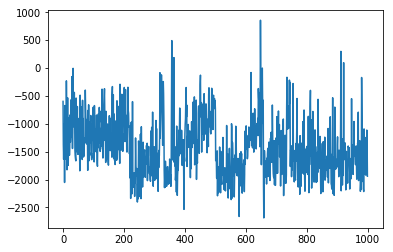

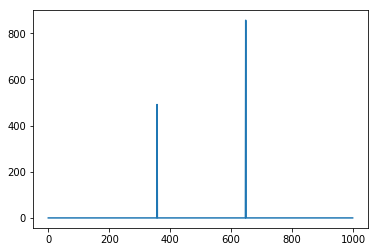

In [80]:
layer=700
plt.figure(1)
plt.plot(classActivationsOfChannels[layer])
plt.figure(2)
plt.plot(topActivationsOfChannels[layer])

maximums = np.argsort(topActivationsOfChannels[layer,:])[-3:] 
print(maximums)
print(classNames[maximums[0]-1])
print(classNames[maximums[1]-1])
print(classNames[maximums[2]-1])

In [101]:
#GET CLASS NAMES
classIndex = 27
print(classNames[classIndex-1])
classIndex = 351
print(classNames[classIndex-1])

soft-coated wheaten terrier
harmonica


In [19]:
print(topActivationsOfChannels[0,:])

[  0.           0.           0.           0.           0.
   0.           0.           0.           0.          55.02765656
   0.           0.           0.           0.           0.
 122.2334938    0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.          53.53648758   0.         155.87058258
   0.           0.           0.           0.           0.
  53.89471817   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  62.07313919   0.          65.65000916   0.           0.
   0.           0.          75.59627533   0.           0.
   0.           0.           0.           0.           0.
   0.          54.03197098   0.           0.           0.
   0.           0.           0.           0.           0.
  60.9523201    0.           0.           0.           0.
   0.           0.         231.33668518   0.         114

In [93]:
#CALCULATE CLASS-SIMILIRATY CONFUSION MATRIX FOR CHANNELS

layer = 40

channelConfusionMatrixes = np.zeros((nbr_classes,nbr_classes,len(layer_indexes[layer])))

for confMatrixIdx,channelIdx in enumerate(layer_indexes[layer]):
    print("channel: " + str(confMatrixIdx+1) + "/" + str(len(layer_indexes[layer])),end='\r')
    for class1 in range(0,nbr_classes-1):
        for class2 in range(class1+1,nbr_classes):
            biggerActivation = max(topActivationsOfChannels[channelIdx,class1],topActivationsOfChannels[channelIdx,class2])
            smallerActivation = min(topActivationsOfChannels[channelIdx,class1],topActivationsOfChannels[channelIdx,class2])
            
            if smallerActivation !=0:
                #store the ratio of the two classes' activation
                channelConfusionMatrixes[class1,class2,confMatrixIdx] = smallerActivation/biggerActivation
                #store the bigger activation as weight
                channelConfusionMatrixes[class2,class1,confMatrixIdx] = biggerActivation
                

In [94]:
#AGGREGATE THE CLASS-SIMILIRATY CONFUSION MATRIXES IN THE LAYER
print("Aggregate the channel confusion matrixes \n")

layerConfusionMatrix = np.zeros((nbr_classes,nbr_classes))

for class1 in range(0,nbr_classes-1):
    for class2 in range(class1+1,nbr_classes):
        sumBiggerActivations = np.sum(channelConfusionMatrixes[class2,class1,:])
        if sumBiggerActivations !=0:
            classRatio = 0
            for confMatrixIdx in range(0,channelConfusionMatrixes.shape[2]):
                classRatio += channelConfusionMatrixes[class2,class1,confMatrixIdx]/sumBiggerActivations*channelConfusionMatrixes[class1,class2,confMatrixIdx]
            layerConfusionMatrix[class1,class2] = classRatio*255
            layerConfusionMatrix[class2,class1] = classRatio*255
            #layerConfusionMatrix[class2,class1] = sumBiggerActivations

    
toimage(layerConfusionMatrix[:,:]).show()
print(layerConfusionMatrix)

Aggregate the channel confusion matrixes 

[[  0.         199.98594498 206.49034312 ...   0.         225.55583475
    0.        ]
 [199.98594498   0.         241.23945684 ... 254.93075524 229.92909905
    0.        ]
 [206.49034312 241.23945684   0.         ...   0.           0.
    0.        ]
 ...
 [  0.         254.93075524   0.         ...   0.         172.59022882
  194.15263487]
 [225.55583475 229.92909905   0.         ... 172.59022882   0.
    0.        ]
 [  0.           0.           0.         ... 194.15263487   0.
    0.        ]]


In [88]:
#REORDER CONFUSION MATRIX BY THE REVERSE CUTHILL-McKEE ALGORITHM

toimage(layerConfusionMatrix[:,:]).show()

sparseLayerConfusionMatrix = sparse.csr_matrix(layerConfusionMatrix)

newOrder = sparse.csgraph.reverse_cuthill_mckee(sparseLayerConfusionMatrix)
reorderedLayerConfusionMatrix = layerConfusionMatrix[newOrder,:][:,newOrder]

toimage(reorderedLayerConfusionMatrix[:,:]).show()

In [74]:
for classidx,classname in enumerate(classNames):
    print(str(classidx) + " " + classname)

for classidx,reorderedClassidx in enumerate(newOrder):
    print(str(classidx) + " " + str(reorderedClassidx) + " " + classNames[reorderedClassidx])


0 dummy
1 kit fox
2 English setter
3 Siberian husky
4 Australian terrier
5 English springer
6 grey whale
7 lesser panda
8 Egyptian cat
9 ibex
10 Persian cat
11 cougar
12 gazelle
13 porcupine
14 sea lion
15 malamute
16 badger
17 Great Dane
18 Walker hound
19 Welsh springer spaniel
20 whippet
21 Scottish deerhound
22 killer whale
23 mink
24 African elephant
25 Weimaraner
26 soft-coated wheaten terrier
27 Dandie Dinmont
28 red wolf
29 Old English sheepdog
30 jaguar
31 otterhound
32 bloodhound
33 Airedale
34 hyena
35 meerkat
36 giant schnauzer
37 titi
38 three-toed sloth
39 sorrel
40 black-footed ferret
41 dalmatian
42 black-and-tan coonhound
43 papillon
44 skunk
45 Staffordshire bullterrier
46 Mexican hairless
47 Bouvier des Flandres
48 weasel
49 miniature poodle
50 Cardigan
51 malinois
52 bighorn
53 fox squirrel
54 colobus
55 tiger cat
56 Lhasa
57 impala
58 coyote
59 Yorkshire terrier
60 Newfoundland
61 brown bear
62 red fox
63 Norwegian elkhound
64 Rottweiler
65 hartebeest
66 Saluki
67 

In [37]:
#GET CONNECTION STATISTIC BASED ON THE LAYER CONFLUENCE MATRIX
np.count_nonzero(layerConfusionMatrix)

connectionStatistic = []

for class1 in range(0,nbr_classes-1):
    for class2 in range(class1+1,nbr_classes):
        if layerConfusionMatrix[class1,class2]!=0:
            connectionStatistic.append([class1,class2,layerConfusionMatrix[class1,class2],layerConfusionMatrix[class2,class1]])
            #print(str(class1) + " " + str(class2) + " " + str(layerConfusionMatrix[class1,class2]) + " " + str(layerConfusionMatrix[class2,class1]))


def takeSecond(elem):
    return elem[3]

# sort list with key
connectionStatistic.sort(key=takeSecond,reverse=True)
        

np.set_printoptions(precision=3)
for classPair in connectionStatistic:
    print(classPair, end='\n')

In [21]:
#GET CLASS NAMES
classIndex = 27
print(classNames[classIndex-1])
classIndex = 57
print(classNames[classIndex-1])

soft-coated wheaten terrier
Lhasa


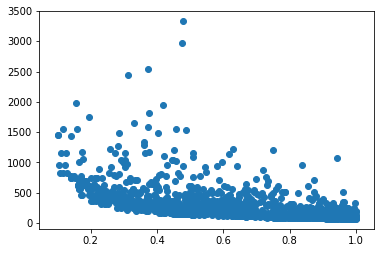

In [19]:
#PLOT THE CONNECTION WEIGHTS (SUM BIGGER ACTIVATIONS) RESPECT TO THE CALCULATED CLASS SIMILIRATY VALUE
connectionStatistic = np.asarray(connectionStatistic)  
plt.scatter(connectionStatistic[:,2],connectionStatistic[:,3])
plt.rcParams["figure.figsize"] = (60,50)

Layer 0 mostActivations: 8.390625
Layer 1 mostActivations: 6.6328125
Layer 2 mostActivations: 5.875
Layer 3 mostActivations: 6.96875
Layer 4 mostActivations: 6.5859375
Layer 5 mostActivations: 6.28125
Layer 6 mostActivations: 7.4453125
Layer 7 mostActivations: 7.5078125
Layer 8 mostActivations: 7.4765625
Layer 9 mostActivations: 6.546875
Layer 10 mostActivations: 8.0703125
Layer 11 mostActivations: 8.2265625
Layer 12 mostActivations: 7.6796875
Layer 13 mostActivations: 7.78125
Layer 14 mostActivations: 7.0390625
Layer 15 mostActivations: 8.4375
Layer 16 mostActivations: 9.0546875
Layer 17 mostActivations: 8.8359375
Layer 18 mostActivations: 9.4765625
Layer 19 mostActivations: 8.5078125
Layer 20 mostActivations: 9.40625
Layer 21 mostActivations: 9.3203125
Layer 22 mostActivations: 9.0625
Layer 23 mostActivations: 10.0859375
Layer 24 mostActivations: 9.234375
Layer 25 mostActivations: 10.734375
Layer 26 mostActivations: 10.6484375
Layer 27 mostActivations: 10.671875
Layer 28 mostActivati

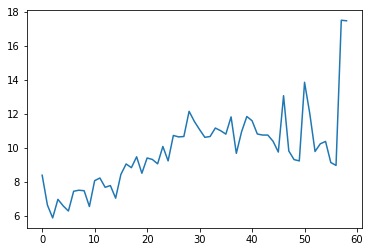

In [46]:
#MOST ACTIVATIONS IN LAYERS

#plt.plot(mostActivations)

mostActivations_layers = np.zeros(len(layers))

channelIdx = 0
for layerIndx in range(0,len(layers)):
    nbrOfChannels = int(layers[idx].shape[3])
    mostActivations_layers[layerIndx] = np.average(mostActivations[channelIdx:(channelIdx+nbrOfChannels)])
    channelIdx +=nbrOfChannels
    print("Layer " + str(layerIndx) + " mostActivations: " + str(mostActivations_layers[layerIndx]))

plt.plot(mostActivations_layers)

In [376]:
#GET X% OF THE MAXIMUM ACTIVATIONS OF A CHANNEL
import matplotlib.pyplot as plt

nbr_classes = 1000
activationPercentThr = 0.9

topActivationsOfChannels = []
splitPoints = np.zeros((all_activation.shape[1]))

for channelNbr in range(0,all_activation.shape[1]):

    channelActivations = all_activation[:,channelNbr]
    maxActivations = np.sort(channelActivations)[::-1]
    maxActivationsIndexes = np.argsort(channelActivations)
    
    maxActivations[np.where(maxActivations<0)] = 0
    
    splitPoint = 1
    while np.sum(maxActivations[:splitPoint])/np.sum(maxActivations)<activationPercentThr:
        splitPoint += 1
        
    print("Splitpoint: " + str(splitPoint))
    splitPoints[channelNbr] = splitPoint

    maxActivationClasses = grountTruth[maxActivationsIndexes[:splitPoint]]
    
    classActivations,bins = np.histogram(maxActivationClasses,bins=nbr_classes)
    print("Channel number: " + str(channelNbr) + " Max activation class: " + str(max(classActivations)))
       
        

Splitpoint: 18563
Channel number: 0 Max activation class: 46
Splitpoint: 18696
Channel number: 1 Max activation class: 45
Splitpoint: 19256
Channel number: 2 Max activation class: 39
Splitpoint: 14763
Channel number: 3 Max activation class: 46
Splitpoint: 16383
Channel number: 4 Max activation class: 45
Splitpoint: 17758
Channel number: 5 Max activation class: 45
Splitpoint: 22796
Channel number: 6 Max activation class: 50
Splitpoint: 19532
Channel number: 7 Max activation class: 43
Splitpoint: 14830
Channel number: 8 Max activation class: 41
Splitpoint: 17539
Channel number: 9 Max activation class: 50
Splitpoint: 12953
Channel number: 10 Max activation class: 48
Splitpoint: 23404
Channel number: 11 Max activation class: 50
Splitpoint: 13341
Channel number: 12 Max activation class: 48
Splitpoint: 23904
Channel number: 13 Max activation class: 50
Splitpoint: 19715
Channel number: 14 Max activation class: 46
Splitpoint: 11353
Channel number: 15 Max activation class: 35
Splitpoint: 18694


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Splitpoint: 13238
Channel number: 132 Max activation class: 44
Splitpoint: 61
Channel number: 133 Max activation class: 3
Splitpoint: 3124
Channel number: 134 Max activation class: 31
Splitpoint: 1
Channel number: 135 Max activation class: 1
Splitpoint: 1
Channel number: 136 Max activation class: 1
Splitpoint: 1958
Channel number: 137 Max activation class: 19
Splitpoint: 55
Channel number: 138 Max activation class: 3
Splitpoint: 9
Channel number: 139 Max activation class: 1
Splitpoint: 8537
Channel number: 140 Max activation class: 36
Splitpoint: 855
Channel number: 141 Max activation class: 19
Splitpoint: 48
Channel number: 142 Max activation class: 6
Splitpoint: 3
Channel number: 143 Max activation class: 1
Splitpoint: 126
Channel number: 144 Max activation class: 7
Splitpoint: 2
Channel number: 145 Max activation class: 2
Splitpoint: 2
Channel number: 146 Max activation class: 1
Splitpoint: 93
Channel number: 147 Max activation class: 3
Splitpoint: 6
Channel number: 148 Max activati

Splitpoint: 15887
Channel number: 271 Max activation class: 47
Splitpoint: 1687
Channel number: 272 Max activation class: 13
Splitpoint: 4
Channel number: 273 Max activation class: 1
Splitpoint: 1
Channel number: 274 Max activation class: 1
Splitpoint: 1028
Channel number: 275 Max activation class: 20
Splitpoint: 10096
Channel number: 276 Max activation class: 50
Splitpoint: 1
Channel number: 277 Max activation class: 1
Splitpoint: 428
Channel number: 278 Max activation class: 33
Splitpoint: 3
Channel number: 279 Max activation class: 1
Splitpoint: 1
Channel number: 280 Max activation class: 1
Splitpoint: 4
Channel number: 281 Max activation class: 1
Splitpoint: 1
Channel number: 282 Max activation class: 1
Splitpoint: 3036
Channel number: 283 Max activation class: 43
Splitpoint: 20
Channel number: 284 Max activation class: 2
Splitpoint: 74
Channel number: 285 Max activation class: 4
Splitpoint: 881
Channel number: 286 Max activation class: 11
Splitpoint: 18810
Channel number: 287 Max 

Splitpoint: 11758
Channel number: 405 Max activation class: 44
Splitpoint: 31133
Channel number: 406 Max activation class: 50
Splitpoint: 27346
Channel number: 407 Max activation class: 50
Splitpoint: 31961
Channel number: 408 Max activation class: 50
Splitpoint: 23768
Channel number: 409 Max activation class: 49
Splitpoint: 40093
Channel number: 410 Max activation class: 50
Splitpoint: 14588
Channel number: 411 Max activation class: 50
Splitpoint: 28640
Channel number: 412 Max activation class: 50
Splitpoint: 2056
Channel number: 413 Max activation class: 22
Splitpoint: 31623
Channel number: 414 Max activation class: 50
Splitpoint: 30847
Channel number: 415 Max activation class: 50
Splitpoint: 31961
Channel number: 416 Max activation class: 50
Splitpoint: 36116
Channel number: 417 Max activation class: 50
Splitpoint: 36560
Channel number: 418 Max activation class: 50
Splitpoint: 34468
Channel number: 419 Max activation class: 50
Splitpoint: 31446
Channel number: 420 Max activation cla

Splitpoint: 28409
Channel number: 536 Max activation class: 50
Splitpoint: 6045
Channel number: 537 Max activation class: 43
Splitpoint: 19761
Channel number: 538 Max activation class: 37
Splitpoint: 20364
Channel number: 539 Max activation class: 50
Splitpoint: 24241
Channel number: 540 Max activation class: 50
Splitpoint: 21500
Channel number: 541 Max activation class: 50
Splitpoint: 35601
Channel number: 542 Max activation class: 50
Splitpoint: 31728
Channel number: 543 Max activation class: 49
Splitpoint: 13138
Channel number: 544 Max activation class: 49
Splitpoint: 2261
Channel number: 545 Max activation class: 13
Splitpoint: 3438
Channel number: 546 Max activation class: 27
Splitpoint: 15589
Channel number: 547 Max activation class: 42
Splitpoint: 34621
Channel number: 548 Max activation class: 50
Splitpoint: 24580
Channel number: 549 Max activation class: 47
Splitpoint: 3756
Channel number: 550 Max activation class: 24
Splitpoint: 29658
Channel number: 551 Max activation class:

Splitpoint: 31816
Channel number: 667 Max activation class: 50
Splitpoint: 16326
Channel number: 668 Max activation class: 45
Splitpoint: 28340
Channel number: 669 Max activation class: 50
Splitpoint: 26945
Channel number: 670 Max activation class: 50
Splitpoint: 15446
Channel number: 671 Max activation class: 46
Splitpoint: 17560
Channel number: 672 Max activation class: 36
Splitpoint: 29477
Channel number: 673 Max activation class: 50
Splitpoint: 16254
Channel number: 674 Max activation class: 40
Splitpoint: 26760
Channel number: 675 Max activation class: 50
Splitpoint: 28324
Channel number: 676 Max activation class: 50
Splitpoint: 25026
Channel number: 677 Max activation class: 49
Splitpoint: 32201
Channel number: 678 Max activation class: 50
Splitpoint: 19556
Channel number: 679 Max activation class: 50
Splitpoint: 23895
Channel number: 680 Max activation class: 49
Splitpoint: 20230
Channel number: 681 Max activation class: 39
Splitpoint: 34059
Channel number: 682 Max activation cl

Splitpoint: 2901
Channel number: 801 Max activation class: 25
Splitpoint: 7638
Channel number: 802 Max activation class: 43
Splitpoint: 13070
Channel number: 803 Max activation class: 45
Splitpoint: 59
Channel number: 804 Max activation class: 5
Splitpoint: 10385
Channel number: 805 Max activation class: 43
Splitpoint: 7952
Channel number: 806 Max activation class: 34
Splitpoint: 10027
Channel number: 807 Max activation class: 40
Splitpoint: 1819
Channel number: 808 Max activation class: 19
Splitpoint: 2788
Channel number: 809 Max activation class: 35
Splitpoint: 2060
Channel number: 810 Max activation class: 21
Splitpoint: 3921
Channel number: 811 Max activation class: 38
Splitpoint: 6114
Channel number: 812 Max activation class: 48
Splitpoint: 1772
Channel number: 813 Max activation class: 36
Splitpoint: 26540
Channel number: 814 Max activation class: 48
Splitpoint: 15860
Channel number: 815 Max activation class: 47
Splitpoint: 6580
Channel number: 816 Max activation class: 38
Splitp

Splitpoint: 22474
Channel number: 932 Max activation class: 49
Splitpoint: 6119
Channel number: 933 Max activation class: 42
Splitpoint: 11269
Channel number: 934 Max activation class: 48
Splitpoint: 31376
Channel number: 935 Max activation class: 50
Splitpoint: 39392
Channel number: 936 Max activation class: 50
Splitpoint: 4497
Channel number: 937 Max activation class: 33
Splitpoint: 16806
Channel number: 938 Max activation class: 50
Splitpoint: 6616
Channel number: 939 Max activation class: 34
Splitpoint: 21090
Channel number: 940 Max activation class: 50
Splitpoint: 32581
Channel number: 941 Max activation class: 50
Splitpoint: 3313
Channel number: 942 Max activation class: 32
Splitpoint: 8408
Channel number: 943 Max activation class: 33
Splitpoint: 9518
Channel number: 944 Max activation class: 44
Splitpoint: 22
Channel number: 945 Max activation class: 5
Splitpoint: 7
Channel number: 946 Max activation class: 5
Splitpoint: 179
Channel number: 947 Max activation class: 11
Splitpoin

Splitpoint: 5616
Channel number: 1068 Max activation class: 43
Splitpoint: 42
Channel number: 1069 Max activation class: 12
Splitpoint: 1
Channel number: 1070 Max activation class: 1
Splitpoint: 20
Channel number: 1071 Max activation class: 2
Splitpoint: 3281
Channel number: 1072 Max activation class: 38
Splitpoint: 1
Channel number: 1073 Max activation class: 1
Splitpoint: 181
Channel number: 1074 Max activation class: 18
Splitpoint: 1028
Channel number: 1075 Max activation class: 19
Splitpoint: 12
Channel number: 1076 Max activation class: 5
Splitpoint: 3
Channel number: 1077 Max activation class: 1
Splitpoint: 692
Channel number: 1078 Max activation class: 8
Splitpoint: 48
Channel number: 1079 Max activation class: 3
Splitpoint: 104
Channel number: 1080 Max activation class: 3
Splitpoint: 47
Channel number: 1081 Max activation class: 4
Splitpoint: 14
Channel number: 1082 Max activation class: 2
Splitpoint: 3353
Channel number: 1083 Max activation class: 33
Splitpoint: 4
Channel numb

Splitpoint: 2
Channel number: 1210 Max activation class: 1
Splitpoint: 1
Channel number: 1211 Max activation class: 1
Splitpoint: 24
Channel number: 1212 Max activation class: 5
Splitpoint: 5
Channel number: 1213 Max activation class: 1
Splitpoint: 1
Channel number: 1214 Max activation class: 1
Splitpoint: 19
Channel number: 1215 Max activation class: 2
Splitpoint: 1
Channel number: 1216 Max activation class: 1
Splitpoint: 1
Channel number: 1217 Max activation class: 1
Splitpoint: 5
Channel number: 1218 Max activation class: 4
Splitpoint: 88
Channel number: 1219 Max activation class: 4
Splitpoint: 20188
Channel number: 1220 Max activation class: 48
Splitpoint: 1345
Channel number: 1221 Max activation class: 17
Splitpoint: 1
Channel number: 1222 Max activation class: 1
Splitpoint: 3
Channel number: 1223 Max activation class: 2
Splitpoint: 2
Channel number: 1224 Max activation class: 1
Splitpoint: 1084
Channel number: 1225 Max activation class: 18
Splitpoint: 164
Channel number: 1226 Max

Splitpoint: 5165
Channel number: 1344 Max activation class: 48
Splitpoint: 18542
Channel number: 1345 Max activation class: 50
Splitpoint: 6538
Channel number: 1346 Max activation class: 30
Splitpoint: 8295
Channel number: 1347 Max activation class: 42
Splitpoint: 9683
Channel number: 1348 Max activation class: 40
Splitpoint: 4724
Channel number: 1349 Max activation class: 30
Splitpoint: 3520
Channel number: 1350 Max activation class: 29
Splitpoint: 1157
Channel number: 1351 Max activation class: 18
Splitpoint: 12505
Channel number: 1352 Max activation class: 39
Splitpoint: 10794
Channel number: 1353 Max activation class: 47
Splitpoint: 12055
Channel number: 1354 Max activation class: 46
Splitpoint: 638
Channel number: 1355 Max activation class: 17
Splitpoint: 3297
Channel number: 1356 Max activation class: 26
Splitpoint: 21241
Channel number: 1357 Max activation class: 49
Splitpoint: 24301
Channel number: 1358 Max activation class: 50
Splitpoint: 22089
Channel number: 1359 Max activat

Splitpoint: 8934
Channel number: 1475 Max activation class: 41
Splitpoint: 22722
Channel number: 1476 Max activation class: 47
Splitpoint: 6599
Channel number: 1477 Max activation class: 42
Splitpoint: 30495
Channel number: 1478 Max activation class: 50
Splitpoint: 10327
Channel number: 1479 Max activation class: 47
Splitpoint: 8673
Channel number: 1480 Max activation class: 49
Splitpoint: 3401
Channel number: 1481 Max activation class: 30
Splitpoint: 5319
Channel number: 1482 Max activation class: 25
Splitpoint: 5135
Channel number: 1483 Max activation class: 34
Splitpoint: 7226
Channel number: 1484 Max activation class: 32
Splitpoint: 4295
Channel number: 1485 Max activation class: 32
Splitpoint: 12187
Channel number: 1486 Max activation class: 46
Splitpoint: 36486
Channel number: 1487 Max activation class: 50
Splitpoint: 9781
Channel number: 1488 Max activation class: 41
Splitpoint: 14419
Channel number: 1489 Max activation class: 50
Splitpoint: 5501
Channel number: 1490 Max activat

Splitpoint: 32597
Channel number: 1604 Max activation class: 50
Splitpoint: 29575
Channel number: 1605 Max activation class: 50
Splitpoint: 40436
Channel number: 1606 Max activation class: 50
Splitpoint: 20263
Channel number: 1607 Max activation class: 50
Splitpoint: 22283
Channel number: 1608 Max activation class: 50
Splitpoint: 34140
Channel number: 1609 Max activation class: 50
Splitpoint: 32912
Channel number: 1610 Max activation class: 50
Splitpoint: 37683
Channel number: 1611 Max activation class: 50
Splitpoint: 16841
Channel number: 1612 Max activation class: 49
Splitpoint: 40686
Channel number: 1613 Max activation class: 50
Splitpoint: 22498
Channel number: 1614 Max activation class: 50
Splitpoint: 20706
Channel number: 1615 Max activation class: 50
Splitpoint: 2211
Channel number: 1616 Max activation class: 23
Splitpoint: 5536
Channel number: 1617 Max activation class: 42
Splitpoint: 3195
Channel number: 1618 Max activation class: 22
Splitpoint: 1516
Channel number: 1619 Max a

Splitpoint: 6645
Channel number: 1743 Max activation class: 34
Splitpoint: 2
Channel number: 1744 Max activation class: 1
Splitpoint: 13331
Channel number: 1745 Max activation class: 43
Splitpoint: 55
Channel number: 1746 Max activation class: 13
Splitpoint: 1992
Channel number: 1747 Max activation class: 36
Splitpoint: 7
Channel number: 1748 Max activation class: 1
Splitpoint: 1
Channel number: 1749 Max activation class: 1
Splitpoint: 5999
Channel number: 1750 Max activation class: 44
Splitpoint: 997
Channel number: 1751 Max activation class: 26
Splitpoint: 259
Channel number: 1752 Max activation class: 7
Splitpoint: 274
Channel number: 1753 Max activation class: 10
Splitpoint: 87
Channel number: 1754 Max activation class: 13
Splitpoint: 16
Channel number: 1755 Max activation class: 4
Splitpoint: 4
Channel number: 1756 Max activation class: 2
Splitpoint: 504
Channel number: 1757 Max activation class: 19
Splitpoint: 15880
Channel number: 1758 Max activation class: 50
Splitpoint: 529
Ch

Splitpoint: 30176
Channel number: 1879 Max activation class: 48
Splitpoint: 33
Channel number: 1880 Max activation class: 2
Splitpoint: 2
Channel number: 1881 Max activation class: 1
Splitpoint: 699
Channel number: 1882 Max activation class: 6
Splitpoint: 8850
Channel number: 1883 Max activation class: 44
Splitpoint: 1552
Channel number: 1884 Max activation class: 30
Splitpoint: 20984
Channel number: 1885 Max activation class: 50
Splitpoint: 2286
Channel number: 1886 Max activation class: 29
Splitpoint: 5366
Channel number: 1887 Max activation class: 32
Splitpoint: 15078
Channel number: 1888 Max activation class: 50
Splitpoint: 12149
Channel number: 1889 Max activation class: 42
Splitpoint: 16982
Channel number: 1890 Max activation class: 46
Splitpoint: 15617
Channel number: 1891 Max activation class: 50
Splitpoint: 2059
Channel number: 1892 Max activation class: 34
Splitpoint: 3775
Channel number: 1893 Max activation class: 36
Splitpoint: 2409
Channel number: 1894 Max activation class

Splitpoint: 18345
Channel number: 2009 Max activation class: 47
Splitpoint: 16549
Channel number: 2010 Max activation class: 47
Splitpoint: 27837
Channel number: 2011 Max activation class: 50
Splitpoint: 19502
Channel number: 2012 Max activation class: 47
Splitpoint: 15190
Channel number: 2013 Max activation class: 48
Splitpoint: 20564
Channel number: 2014 Max activation class: 49
Splitpoint: 7814
Channel number: 2015 Max activation class: 31
Splitpoint: 14482
Channel number: 2016 Max activation class: 43
Splitpoint: 11982
Channel number: 2017 Max activation class: 42
Splitpoint: 17861
Channel number: 2018 Max activation class: 49
Splitpoint: 11989
Channel number: 2019 Max activation class: 48
Splitpoint: 17938
Channel number: 2020 Max activation class: 48
Splitpoint: 23552
Channel number: 2021 Max activation class: 50
Splitpoint: 16729
Channel number: 2022 Max activation class: 50
Splitpoint: 26927
Channel number: 2023 Max activation class: 50
Splitpoint: 28787
Channel number: 2024 Ma

Splitpoint: 24245
Channel number: 2138 Max activation class: 49
Splitpoint: 26214
Channel number: 2139 Max activation class: 49
Splitpoint: 29071
Channel number: 2140 Max activation class: 50
Splitpoint: 25957
Channel number: 2141 Max activation class: 50
Splitpoint: 13848
Channel number: 2142 Max activation class: 45
Splitpoint: 30658
Channel number: 2143 Max activation class: 50
Splitpoint: 29680
Channel number: 2144 Max activation class: 50
Splitpoint: 24589
Channel number: 2145 Max activation class: 50
Splitpoint: 14104
Channel number: 2146 Max activation class: 48
Splitpoint: 34326
Channel number: 2147 Max activation class: 50
Splitpoint: 32798
Channel number: 2148 Max activation class: 50
Splitpoint: 33876
Channel number: 2149 Max activation class: 50
Splitpoint: 32490
Channel number: 2150 Max activation class: 50
Splitpoint: 18554
Channel number: 2151 Max activation class: 50
Splitpoint: 34468
Channel number: 2152 Max activation class: 50
Splitpoint: 17276
Channel number: 2153 M

Splitpoint: 7426
Channel number: 2271 Max activation class: 37
Splitpoint: 2709
Channel number: 2272 Max activation class: 35
Splitpoint: 1834
Channel number: 2273 Max activation class: 32
Splitpoint: 784
Channel number: 2274 Max activation class: 22
Splitpoint: 18409
Channel number: 2275 Max activation class: 46
Splitpoint: 7547
Channel number: 2276 Max activation class: 50
Splitpoint: 9071
Channel number: 2277 Max activation class: 45
Splitpoint: 2831
Channel number: 2278 Max activation class: 30
Splitpoint: 3334
Channel number: 2279 Max activation class: 31
Splitpoint: 4437
Channel number: 2280 Max activation class: 33
Splitpoint: 14828
Channel number: 2281 Max activation class: 49
Splitpoint: 1524
Channel number: 2282 Max activation class: 25
Splitpoint: 1456
Channel number: 2283 Max activation class: 21
Splitpoint: 15424
Channel number: 2284 Max activation class: 50
Splitpoint: 5878
Channel number: 2285 Max activation class: 32
Splitpoint: 636
Channel number: 2286 Max activation c

Splitpoint: 9610
Channel number: 2403 Max activation class: 47
Splitpoint: 566
Channel number: 2404 Max activation class: 14
Splitpoint: 3314
Channel number: 2405 Max activation class: 23
Splitpoint: 4700
Channel number: 2406 Max activation class: 36
Splitpoint: 4447
Channel number: 2407 Max activation class: 31
Splitpoint: 1322
Channel number: 2408 Max activation class: 41
Splitpoint: 6137
Channel number: 2409 Max activation class: 36
Splitpoint: 7085
Channel number: 2410 Max activation class: 44
Splitpoint: 5205
Channel number: 2411 Max activation class: 39
Splitpoint: 7230
Channel number: 2412 Max activation class: 49
Splitpoint: 3309
Channel number: 2413 Max activation class: 24
Splitpoint: 8503
Channel number: 2414 Max activation class: 49
Splitpoint: 3032
Channel number: 2415 Max activation class: 32
Splitpoint: 15448
Channel number: 2416 Max activation class: 48
Splitpoint: 240
Channel number: 2417 Max activation class: 8
Splitpoint: 10729
Channel number: 2418 Max activation cla

Splitpoint: 15314
Channel number: 2535 Max activation class: 50
Splitpoint: 9431
Channel number: 2536 Max activation class: 43
Splitpoint: 2073
Channel number: 2537 Max activation class: 37
Splitpoint: 10067
Channel number: 2538 Max activation class: 37
Splitpoint: 16192
Channel number: 2539 Max activation class: 45
Splitpoint: 11748
Channel number: 2540 Max activation class: 44
Splitpoint: 694
Channel number: 2541 Max activation class: 18
Splitpoint: 12210
Channel number: 2542 Max activation class: 46
Splitpoint: 1523
Channel number: 2543 Max activation class: 33
Splitpoint: 7095
Channel number: 2544 Max activation class: 40
Splitpoint: 2054
Channel number: 2545 Max activation class: 14
Splitpoint: 2280
Channel number: 2546 Max activation class: 38
Splitpoint: 6909
Channel number: 2547 Max activation class: 35
Splitpoint: 4077
Channel number: 2548 Max activation class: 42
Splitpoint: 5682
Channel number: 2549 Max activation class: 37
Splitpoint: 2077
Channel number: 2550 Max activatio

Splitpoint: 20091
Channel number: 2666 Max activation class: 48
Splitpoint: 16723
Channel number: 2667 Max activation class: 49
Splitpoint: 22084
Channel number: 2668 Max activation class: 50
Splitpoint: 7897
Channel number: 2669 Max activation class: 40
Splitpoint: 16776
Channel number: 2670 Max activation class: 50
Splitpoint: 1142
Channel number: 2671 Max activation class: 16
Splitpoint: 2342
Channel number: 2672 Max activation class: 20
Splitpoint: 21951
Channel number: 2673 Max activation class: 49
Splitpoint: 2522
Channel number: 2674 Max activation class: 23
Splitpoint: 1011
Channel number: 2675 Max activation class: 22
Splitpoint: 9038
Channel number: 2676 Max activation class: 39
Splitpoint: 5894
Channel number: 2677 Max activation class: 49
Splitpoint: 12453
Channel number: 2678 Max activation class: 50
Splitpoint: 14113
Channel number: 2679 Max activation class: 42
Splitpoint: 7052
Channel number: 2680 Max activation class: 45
Splitpoint: 20609
Channel number: 2681 Max activ

Splitpoint: 26142
Channel number: 2795 Max activation class: 50
Splitpoint: 3686
Channel number: 2796 Max activation class: 40
Splitpoint: 14070
Channel number: 2797 Max activation class: 46
Splitpoint: 11818
Channel number: 2798 Max activation class: 49
Splitpoint: 18243
Channel number: 2799 Max activation class: 49
Splitpoint: 35526
Channel number: 2800 Max activation class: 50
Splitpoint: 28444
Channel number: 2801 Max activation class: 50
Splitpoint: 7411
Channel number: 2802 Max activation class: 38
Splitpoint: 23285
Channel number: 2803 Max activation class: 49
Splitpoint: 27899
Channel number: 2804 Max activation class: 50
Splitpoint: 28972
Channel number: 2805 Max activation class: 48
Splitpoint: 28648
Channel number: 2806 Max activation class: 50
Splitpoint: 15626
Channel number: 2807 Max activation class: 50
Splitpoint: 10349
Channel number: 2808 Max activation class: 45
Splitpoint: 12635
Channel number: 2809 Max activation class: 43
Splitpoint: 12598
Channel number: 2810 Max

Splitpoint: 4590
Channel number: 2927 Max activation class: 33
Splitpoint: 1777
Channel number: 2928 Max activation class: 26
Splitpoint: 8346
Channel number: 2929 Max activation class: 46
Splitpoint: 4342
Channel number: 2930 Max activation class: 41
Splitpoint: 1157
Channel number: 2931 Max activation class: 15
Splitpoint: 5482
Channel number: 2932 Max activation class: 36
Splitpoint: 2998
Channel number: 2933 Max activation class: 39
Splitpoint: 12212
Channel number: 2934 Max activation class: 46
Splitpoint: 10693
Channel number: 2935 Max activation class: 44
Splitpoint: 449
Channel number: 2936 Max activation class: 22
Splitpoint: 10783
Channel number: 2937 Max activation class: 48
Splitpoint: 1178
Channel number: 2938 Max activation class: 38
Splitpoint: 1894
Channel number: 2939 Max activation class: 21
Splitpoint: 558
Channel number: 2940 Max activation class: 14
Splitpoint: 6204
Channel number: 2941 Max activation class: 39
Splitpoint: 7474
Channel number: 2942 Max activation c

Splitpoint: 2251
Channel number: 3060 Max activation class: 27
Splitpoint: 510
Channel number: 3061 Max activation class: 20
Splitpoint: 1639
Channel number: 3062 Max activation class: 20
Splitpoint: 532
Channel number: 3063 Max activation class: 12
Splitpoint: 12819
Channel number: 3064 Max activation class: 49
Splitpoint: 4100
Channel number: 3065 Max activation class: 25
Splitpoint: 7742
Channel number: 3066 Max activation class: 47
Splitpoint: 656
Channel number: 3067 Max activation class: 16
Splitpoint: 8021
Channel number: 3068 Max activation class: 36
Splitpoint: 6860
Channel number: 3069 Max activation class: 41
Splitpoint: 5769
Channel number: 3070 Max activation class: 45
Splitpoint: 7446
Channel number: 3071 Max activation class: 42
Splitpoint: 1942
Channel number: 3072 Max activation class: 30
Splitpoint: 10320
Channel number: 3073 Max activation class: 45
Splitpoint: 2893
Channel number: 3074 Max activation class: 24
Splitpoint: 3989
Channel number: 3075 Max activation cla

Splitpoint: 3761
Channel number: 3192 Max activation class: 43
Splitpoint: 20
Channel number: 3193 Max activation class: 1
Splitpoint: 656
Channel number: 3194 Max activation class: 17
Splitpoint: 219
Channel number: 3195 Max activation class: 10
Splitpoint: 690
Channel number: 3196 Max activation class: 27
Splitpoint: 764
Channel number: 3197 Max activation class: 19
Splitpoint: 281
Channel number: 3198 Max activation class: 19
Splitpoint: 1374
Channel number: 3199 Max activation class: 30
Splitpoint: 5036
Channel number: 3200 Max activation class: 40
Splitpoint: 6588
Channel number: 3201 Max activation class: 33
Splitpoint: 3546
Channel number: 3202 Max activation class: 34
Splitpoint: 570
Channel number: 3203 Max activation class: 20
Splitpoint: 5765
Channel number: 3204 Max activation class: 48
Splitpoint: 3185
Channel number: 3205 Max activation class: 21
Splitpoint: 3715
Channel number: 3206 Max activation class: 36
Splitpoint: 1065
Channel number: 3207 Max activation class: 16
S

Splitpoint: 7750
Channel number: 3326 Max activation class: 39
Splitpoint: 8547
Channel number: 3327 Max activation class: 45
Splitpoint: 6103
Channel number: 3328 Max activation class: 44
Splitpoint: 2883
Channel number: 3329 Max activation class: 26
Splitpoint: 3633
Channel number: 3330 Max activation class: 45
Splitpoint: 24251
Channel number: 3331 Max activation class: 50
Splitpoint: 10177
Channel number: 3332 Max activation class: 44
Splitpoint: 1163
Channel number: 3333 Max activation class: 22
Splitpoint: 468
Channel number: 3334 Max activation class: 15
Splitpoint: 12180
Channel number: 3335 Max activation class: 46
Splitpoint: 1048
Channel number: 3336 Max activation class: 17
Splitpoint: 412
Channel number: 3337 Max activation class: 13
Splitpoint: 53
Channel number: 3338 Max activation class: 9
Splitpoint: 9013
Channel number: 3339 Max activation class: 46
Splitpoint: 13672
Channel number: 3340 Max activation class: 49
Splitpoint: 2783
Channel number: 3341 Max activation cla

Splitpoint: 17908
Channel number: 3457 Max activation class: 50
Splitpoint: 6479
Channel number: 3458 Max activation class: 49
Splitpoint: 21787
Channel number: 3459 Max activation class: 50
Splitpoint: 274
Channel number: 3460 Max activation class: 12
Splitpoint: 12204
Channel number: 3461 Max activation class: 49
Splitpoint: 18018
Channel number: 3462 Max activation class: 50
Splitpoint: 3383
Channel number: 3463 Max activation class: 38
Splitpoint: 7998
Channel number: 3464 Max activation class: 39
Splitpoint: 502
Channel number: 3465 Max activation class: 14
Splitpoint: 22922
Channel number: 3466 Max activation class: 50
Splitpoint: 12700
Channel number: 3467 Max activation class: 42
Splitpoint: 7285
Channel number: 3468 Max activation class: 43
Splitpoint: 6803
Channel number: 3469 Max activation class: 39
Splitpoint: 2493
Channel number: 3470 Max activation class: 29
Splitpoint: 11089
Channel number: 3471 Max activation class: 45
Splitpoint: 962
Channel number: 3472 Max activatio

Splitpoint: 5303
Channel number: 3591 Max activation class: 39
Splitpoint: 321
Channel number: 3592 Max activation class: 10
Splitpoint: 44
Channel number: 3593 Max activation class: 3
Splitpoint: 1433
Channel number: 3594 Max activation class: 19
Splitpoint: 1256
Channel number: 3595 Max activation class: 28
Splitpoint: 138
Channel number: 3596 Max activation class: 7
Splitpoint: 1878
Channel number: 3597 Max activation class: 33
Splitpoint: 3874
Channel number: 3598 Max activation class: 44
Splitpoint: 816
Channel number: 3599 Max activation class: 20
Splitpoint: 6910
Channel number: 3600 Max activation class: 42
Splitpoint: 3216
Channel number: 3601 Max activation class: 31
Splitpoint: 1054
Channel number: 3602 Max activation class: 32
Splitpoint: 3237
Channel number: 3603 Max activation class: 37
Splitpoint: 1327
Channel number: 3604 Max activation class: 21
Splitpoint: 236
Channel number: 3605 Max activation class: 10
Splitpoint: 467
Channel number: 3606 Max activation class: 18
S

Channel number: 3723 Max activation class: 20
Splitpoint: 8009
Channel number: 3724 Max activation class: 48
Splitpoint: 475
Channel number: 3725 Max activation class: 14
Splitpoint: 1354
Channel number: 3726 Max activation class: 24
Splitpoint: 5493
Channel number: 3727 Max activation class: 50
Splitpoint: 5771
Channel number: 3728 Max activation class: 48
Splitpoint: 11364
Channel number: 3729 Max activation class: 49
Splitpoint: 197
Channel number: 3730 Max activation class: 9
Splitpoint: 386
Channel number: 3731 Max activation class: 17
Splitpoint: 13637
Channel number: 3732 Max activation class: 49
Splitpoint: 7970
Channel number: 3733 Max activation class: 49
Splitpoint: 38
Channel number: 3734 Max activation class: 2
Splitpoint: 7148
Channel number: 3735 Max activation class: 40
Splitpoint: 6314
Channel number: 3736 Max activation class: 49
Splitpoint: 401
Channel number: 3737 Max activation class: 14
Splitpoint: 596
Channel number: 3738 Max activation class: 16
Splitpoint: 1862

Splitpoint: 1293
Channel number: 3859 Max activation class: 28
Splitpoint: 485
Channel number: 3860 Max activation class: 13
Splitpoint: 24
Channel number: 3861 Max activation class: 4
Splitpoint: 5
Channel number: 3862 Max activation class: 4
Splitpoint: 3
Channel number: 3863 Max activation class: 1
Splitpoint: 21
Channel number: 3864 Max activation class: 3
Splitpoint: 1
Channel number: 3865 Max activation class: 1
Splitpoint: 12
Channel number: 3866 Max activation class: 6
Splitpoint: 11
Channel number: 3867 Max activation class: 2
Splitpoint: 11
Channel number: 3868 Max activation class: 1
Splitpoint: 18189
Channel number: 3869 Max activation class: 50
Splitpoint: 25078
Channel number: 3870 Max activation class: 50
Splitpoint: 12390
Channel number: 3871 Max activation class: 48
Splitpoint: 10
Channel number: 3872 Max activation class: 1
Splitpoint: 15
Channel number: 3873 Max activation class: 3
Splitpoint: 28574
Channel number: 3874 Max activation class: 50
Splitpoint: 907
Channe

Splitpoint: 18384
Channel number: 3993 Max activation class: 49
Splitpoint: 5642
Channel number: 3994 Max activation class: 45
Splitpoint: 13749
Channel number: 3995 Max activation class: 49
Splitpoint: 651
Channel number: 3996 Max activation class: 20
Splitpoint: 2480
Channel number: 3997 Max activation class: 38
Splitpoint: 8208
Channel number: 3998 Max activation class: 42
Splitpoint: 8812
Channel number: 3999 Max activation class: 47
Splitpoint: 3324
Channel number: 4000 Max activation class: 45
Splitpoint: 16933
Channel number: 4001 Max activation class: 47
Splitpoint: 1437
Channel number: 4002 Max activation class: 29
Splitpoint: 2135
Channel number: 4003 Max activation class: 30
Splitpoint: 3887
Channel number: 4004 Max activation class: 47
Splitpoint: 5907
Channel number: 4005 Max activation class: 37
Splitpoint: 9958
Channel number: 4006 Max activation class: 44
Splitpoint: 12591
Channel number: 4007 Max activation class: 49
Splitpoint: 5482
Channel number: 4008 Max activation

Splitpoint: 13170
Channel number: 4123 Max activation class: 44
Splitpoint: 2051
Channel number: 4124 Max activation class: 28
Splitpoint: 3264
Channel number: 4125 Max activation class: 36
Splitpoint: 6717
Channel number: 4126 Max activation class: 38
Splitpoint: 5538
Channel number: 4127 Max activation class: 36
Splitpoint: 3364
Channel number: 4128 Max activation class: 36
Splitpoint: 1939
Channel number: 4129 Max activation class: 21
Splitpoint: 7197
Channel number: 4130 Max activation class: 33
Splitpoint: 11826
Channel number: 4131 Max activation class: 48
Splitpoint: 2451
Channel number: 4132 Max activation class: 27
Splitpoint: 3782
Channel number: 4133 Max activation class: 33
Splitpoint: 13463
Channel number: 4134 Max activation class: 48
Splitpoint: 5403
Channel number: 4135 Max activation class: 40
Splitpoint: 2849
Channel number: 4136 Max activation class: 32
Splitpoint: 2434
Channel number: 4137 Max activation class: 37
Splitpoint: 5892
Channel number: 4138 Max activation

Splitpoint: 28141
Channel number: 4253 Max activation class: 50
Splitpoint: 34454
Channel number: 4254 Max activation class: 50
Splitpoint: 20137
Channel number: 4255 Max activation class: 50
Splitpoint: 33486
Channel number: 4256 Max activation class: 50
Splitpoint: 32156
Channel number: 4257 Max activation class: 50
Splitpoint: 35696
Channel number: 4258 Max activation class: 50
Splitpoint: 31669
Channel number: 4259 Max activation class: 50
Splitpoint: 27930
Channel number: 4260 Max activation class: 50
Splitpoint: 30494
Channel number: 4261 Max activation class: 50
Splitpoint: 38788
Channel number: 4262 Max activation class: 50
Splitpoint: 28334
Channel number: 4263 Max activation class: 50
Splitpoint: 36327
Channel number: 4264 Max activation class: 50
Splitpoint: 9089
Channel number: 4265 Max activation class: 43
Splitpoint: 35452
Channel number: 4266 Max activation class: 50
Splitpoint: 28768
Channel number: 4267 Max activation class: 50
Splitpoint: 32809
Channel number: 4268 Ma

Splitpoint: 9348
Channel number: 4383 Max activation class: 46
Splitpoint: 6618
Channel number: 4384 Max activation class: 41
Splitpoint: 8072
Channel number: 4385 Max activation class: 38
Splitpoint: 10347
Channel number: 4386 Max activation class: 47
Splitpoint: 3476
Channel number: 4387 Max activation class: 48
Splitpoint: 17102
Channel number: 4388 Max activation class: 48
Splitpoint: 11161
Channel number: 4389 Max activation class: 50
Splitpoint: 6548
Channel number: 4390 Max activation class: 46
Splitpoint: 9744
Channel number: 4391 Max activation class: 42
Splitpoint: 2295
Channel number: 4392 Max activation class: 46
Splitpoint: 10986
Channel number: 4393 Max activation class: 50
Splitpoint: 34709
Channel number: 4394 Max activation class: 50
Splitpoint: 4855
Channel number: 4395 Max activation class: 33
Splitpoint: 32435
Channel number: 4396 Max activation class: 50
Splitpoint: 12694
Channel number: 4397 Max activation class: 46
Splitpoint: 2645
Channel number: 4398 Max activa

Splitpoint: 36999
Channel number: 4514 Max activation class: 50
Splitpoint: 1561
Channel number: 4515 Max activation class: 28
Splitpoint: 8447
Channel number: 4516 Max activation class: 49
Splitpoint: 7280
Channel number: 4517 Max activation class: 46
Splitpoint: 2381
Channel number: 4518 Max activation class: 34
Splitpoint: 4954
Channel number: 4519 Max activation class: 33
Splitpoint: 7898
Channel number: 4520 Max activation class: 44
Splitpoint: 7395
Channel number: 4521 Max activation class: 47
Splitpoint: 33442
Channel number: 4522 Max activation class: 50
Splitpoint: 12381
Channel number: 4523 Max activation class: 50
Splitpoint: 1021
Channel number: 4524 Max activation class: 21
Splitpoint: 31618
Channel number: 4525 Max activation class: 50
Splitpoint: 643
Channel number: 4526 Max activation class: 34
Splitpoint: 3282
Channel number: 4527 Max activation class: 31
Splitpoint: 14992
Channel number: 4528 Max activation class: 50
Splitpoint: 4411
Channel number: 4529 Max activatio

Splitpoint: 21963
Channel number: 4645 Max activation class: 50
Splitpoint: 3980
Channel number: 4646 Max activation class: 34
Splitpoint: 12088
Channel number: 4647 Max activation class: 50
Splitpoint: 9045
Channel number: 4648 Max activation class: 44
Splitpoint: 10095
Channel number: 4649 Max activation class: 45
Splitpoint: 12466
Channel number: 4650 Max activation class: 46
Splitpoint: 2585
Channel number: 4651 Max activation class: 43
Splitpoint: 2983
Channel number: 4652 Max activation class: 43
Splitpoint: 3959
Channel number: 4653 Max activation class: 35
Splitpoint: 36695
Channel number: 4654 Max activation class: 50
Splitpoint: 6072
Channel number: 4655 Max activation class: 48
Splitpoint: 5419
Channel number: 4656 Max activation class: 45
Splitpoint: 9750
Channel number: 4657 Max activation class: 46
Splitpoint: 3941
Channel number: 4658 Max activation class: 35
Splitpoint: 6128
Channel number: 4659 Max activation class: 42
Splitpoint: 6411
Channel number: 4660 Max activati

Splitpoint: 2394
Channel number: 4782 Max activation class: 38
Splitpoint: 5130
Channel number: 4783 Max activation class: 46
Splitpoint: 187
Channel number: 4784 Max activation class: 6
Splitpoint: 5701
Channel number: 4785 Max activation class: 40
Splitpoint: 1
Channel number: 4786 Max activation class: 1
Splitpoint: 5431
Channel number: 4787 Max activation class: 39
Splitpoint: 761
Channel number: 4788 Max activation class: 19
Splitpoint: 307
Channel number: 4789 Max activation class: 14
Splitpoint: 4752
Channel number: 4790 Max activation class: 46
Splitpoint: 1213
Channel number: 4791 Max activation class: 34
Splitpoint: 1226
Channel number: 4792 Max activation class: 21
Splitpoint: 1013
Channel number: 4793 Max activation class: 24
Splitpoint: 33
Channel number: 4794 Max activation class: 3
Splitpoint: 544
Channel number: 4795 Max activation class: 9
Splitpoint: 3014
Channel number: 4796 Max activation class: 46
Splitpoint: 6510
Channel number: 4797 Max activation class: 47
Split

Splitpoint: 11690
Channel number: 4914 Max activation class: 38
Splitpoint: 852
Channel number: 4915 Max activation class: 20
Splitpoint: 7685
Channel number: 4916 Max activation class: 46
Splitpoint: 1934
Channel number: 4917 Max activation class: 30
Splitpoint: 7756
Channel number: 4918 Max activation class: 46
Splitpoint: 4373
Channel number: 4919 Max activation class: 44
Splitpoint: 17045
Channel number: 4920 Max activation class: 50
Splitpoint: 4968
Channel number: 4921 Max activation class: 39
Splitpoint: 2115
Channel number: 4922 Max activation class: 31
Splitpoint: 10753
Channel number: 4923 Max activation class: 48
Splitpoint: 10633
Channel number: 4924 Max activation class: 48
Splitpoint: 3272
Channel number: 4925 Max activation class: 28
Splitpoint: 17216
Channel number: 4926 Max activation class: 49
Splitpoint: 5711
Channel number: 4927 Max activation class: 41
Splitpoint: 6901
Channel number: 4928 Max activation class: 31
Splitpoint: 9187
Channel number: 4929 Max activatio

Splitpoint: 7948
Channel number: 5045 Max activation class: 49
Splitpoint: 9486
Channel number: 5046 Max activation class: 47
Splitpoint: 6897
Channel number: 5047 Max activation class: 47
Splitpoint: 13359
Channel number: 5048 Max activation class: 47
Splitpoint: 9020
Channel number: 5049 Max activation class: 44
Splitpoint: 11365
Channel number: 5050 Max activation class: 48
Splitpoint: 7569
Channel number: 5051 Max activation class: 45
Splitpoint: 9939
Channel number: 5052 Max activation class: 42
Splitpoint: 9235
Channel number: 5053 Max activation class: 49
Splitpoint: 18106
Channel number: 5054 Max activation class: 50
Splitpoint: 10580
Channel number: 5055 Max activation class: 45
Splitpoint: 26065
Channel number: 5056 Max activation class: 50
Splitpoint: 14471
Channel number: 5057 Max activation class: 48
Splitpoint: 15699
Channel number: 5058 Max activation class: 49
Splitpoint: 7810
Channel number: 5059 Max activation class: 47
Splitpoint: 23499
Channel number: 5060 Max activ

Splitpoint: 15589
Channel number: 5174 Max activation class: 49
Splitpoint: 15249
Channel number: 5175 Max activation class: 45
Splitpoint: 7896
Channel number: 5176 Max activation class: 50
Splitpoint: 9495
Channel number: 5177 Max activation class: 41
Splitpoint: 8172
Channel number: 5178 Max activation class: 48
Splitpoint: 10956
Channel number: 5179 Max activation class: 43
Splitpoint: 21905
Channel number: 5180 Max activation class: 50
Splitpoint: 13781
Channel number: 5181 Max activation class: 46
Splitpoint: 14356
Channel number: 5182 Max activation class: 47
Splitpoint: 8675
Channel number: 5183 Max activation class: 41
Splitpoint: 10024
Channel number: 5184 Max activation class: 49
Splitpoint: 8590
Channel number: 5185 Max activation class: 45
Splitpoint: 19113
Channel number: 5186 Max activation class: 50
Splitpoint: 9427
Channel number: 5187 Max activation class: 46
Splitpoint: 6228
Channel number: 5188 Max activation class: 40
Splitpoint: 11704
Channel number: 5189 Max acti

Splitpoint: 19693
Channel number: 5303 Max activation class: 50
Splitpoint: 23554
Channel number: 5304 Max activation class: 50
Splitpoint: 21235
Channel number: 5305 Max activation class: 50
Splitpoint: 25404
Channel number: 5306 Max activation class: 50
Splitpoint: 14769
Channel number: 5307 Max activation class: 50
Splitpoint: 19830
Channel number: 5308 Max activation class: 50
Splitpoint: 24720
Channel number: 5309 Max activation class: 50
Splitpoint: 29031
Channel number: 5310 Max activation class: 50
Splitpoint: 17976
Channel number: 5311 Max activation class: 49
Splitpoint: 27269
Channel number: 5312 Max activation class: 50
Splitpoint: 25074
Channel number: 5313 Max activation class: 50
Splitpoint: 24096
Channel number: 5314 Max activation class: 50
Splitpoint: 14432
Channel number: 5315 Max activation class: 49
Splitpoint: 19140
Channel number: 5316 Max activation class: 50
Splitpoint: 20682
Channel number: 5317 Max activation class: 50
Splitpoint: 28171
Channel number: 5318 M

Splitpoint: 6631
Channel number: 5432 Max activation class: 42
Splitpoint: 4789
Channel number: 5433 Max activation class: 45
Splitpoint: 4837
Channel number: 5434 Max activation class: 47
Splitpoint: 4859
Channel number: 5435 Max activation class: 38
Splitpoint: 3464
Channel number: 5436 Max activation class: 38
Splitpoint: 5938
Channel number: 5437 Max activation class: 45
Splitpoint: 3186
Channel number: 5438 Max activation class: 34
Splitpoint: 4002
Channel number: 5439 Max activation class: 43
Splitpoint: 2032
Channel number: 5440 Max activation class: 34
Splitpoint: 6689
Channel number: 5441 Max activation class: 41
Splitpoint: 7189
Channel number: 5442 Max activation class: 46
Splitpoint: 3284
Channel number: 5443 Max activation class: 30
Splitpoint: 5030
Channel number: 5444 Max activation class: 43
Splitpoint: 2290
Channel number: 5445 Max activation class: 30
Splitpoint: 3704
Channel number: 5446 Max activation class: 42
Splitpoint: 3677
Channel number: 5447 Max activation cl

Splitpoint: 8877
Channel number: 5563 Max activation class: 50
Splitpoint: 7034
Channel number: 5564 Max activation class: 48
Splitpoint: 4341
Channel number: 5565 Max activation class: 42
Splitpoint: 4376
Channel number: 5566 Max activation class: 42
Splitpoint: 5242
Channel number: 5567 Max activation class: 42
Splitpoint: 2518
Channel number: 5568 Max activation class: 30
Splitpoint: 3196
Channel number: 5569 Max activation class: 47
Splitpoint: 3098
Channel number: 5570 Max activation class: 41
Splitpoint: 5445
Channel number: 5571 Max activation class: 47
Splitpoint: 3933
Channel number: 5572 Max activation class: 48
Splitpoint: 6130
Channel number: 5573 Max activation class: 42
Splitpoint: 7701
Channel number: 5574 Max activation class: 48
Splitpoint: 9138
Channel number: 5575 Max activation class: 41
Splitpoint: 4396
Channel number: 5576 Max activation class: 46
Splitpoint: 4862
Channel number: 5577 Max activation class: 42
Splitpoint: 8262
Channel number: 5578 Max activation cl

Splitpoint: 7147
Channel number: 5695 Max activation class: 47
Splitpoint: 4189
Channel number: 5696 Max activation class: 41
Splitpoint: 4363
Channel number: 5697 Max activation class: 44
Splitpoint: 8067
Channel number: 5698 Max activation class: 47
Splitpoint: 3609
Channel number: 5699 Max activation class: 39
Splitpoint: 8073
Channel number: 5700 Max activation class: 43
Splitpoint: 8352
Channel number: 5701 Max activation class: 50
Splitpoint: 3341
Channel number: 5702 Max activation class: 32
Splitpoint: 5281
Channel number: 5703 Max activation class: 43
Splitpoint: 3150
Channel number: 5704 Max activation class: 35
Splitpoint: 4508
Channel number: 5705 Max activation class: 41
Splitpoint: 3267
Channel number: 5706 Max activation class: 48
Splitpoint: 11141
Channel number: 5707 Max activation class: 49
Splitpoint: 3385
Channel number: 5708 Max activation class: 35
Splitpoint: 4296
Channel number: 5709 Max activation class: 44
Splitpoint: 10684
Channel number: 5710 Max activation 

Splitpoint: 7234
Channel number: 5825 Max activation class: 47
Splitpoint: 10802
Channel number: 5826 Max activation class: 50
Splitpoint: 1667
Channel number: 5827 Max activation class: 26
Splitpoint: 2907
Channel number: 5828 Max activation class: 34
Splitpoint: 290
Channel number: 5829 Max activation class: 22
Splitpoint: 1067
Channel number: 5830 Max activation class: 22
Splitpoint: 137
Channel number: 5831 Max activation class: 6
Splitpoint: 680
Channel number: 5832 Max activation class: 12
Splitpoint: 934
Channel number: 5833 Max activation class: 31
Splitpoint: 523
Channel number: 5834 Max activation class: 18
Splitpoint: 3695
Channel number: 5835 Max activation class: 36
Splitpoint: 6028
Channel number: 5836 Max activation class: 40
Splitpoint: 2265
Channel number: 5837 Max activation class: 32
Splitpoint: 3345
Channel number: 5838 Max activation class: 48
Splitpoint: 4709
Channel number: 5839 Max activation class: 43
Splitpoint: 5849
Channel number: 5840 Max activation class: 

Splitpoint: 15402
Channel number: 5955 Max activation class: 49
Splitpoint: 4025
Channel number: 5956 Max activation class: 38
Splitpoint: 8699
Channel number: 5957 Max activation class: 50
Splitpoint: 9732
Channel number: 5958 Max activation class: 49
Splitpoint: 6446
Channel number: 5959 Max activation class: 40
Splitpoint: 10325
Channel number: 5960 Max activation class: 46
Splitpoint: 8848
Channel number: 5961 Max activation class: 49
Splitpoint: 11036
Channel number: 5962 Max activation class: 49
Splitpoint: 12656
Channel number: 5963 Max activation class: 49
Splitpoint: 6721
Channel number: 5964 Max activation class: 44
Splitpoint: 5309
Channel number: 5965 Max activation class: 39
Splitpoint: 16796
Channel number: 5966 Max activation class: 50
Splitpoint: 17854
Channel number: 5967 Max activation class: 49
Splitpoint: 6476
Channel number: 5968 Max activation class: 48
Splitpoint: 9463
Channel number: 5969 Max activation class: 49
Splitpoint: 4964
Channel number: 5970 Max activat

Splitpoint: 1632
Channel number: 6085 Max activation class: 30
Splitpoint: 2725
Channel number: 6086 Max activation class: 45
Splitpoint: 1310
Channel number: 6087 Max activation class: 27
Splitpoint: 1189
Channel number: 6088 Max activation class: 17
Splitpoint: 597
Channel number: 6089 Max activation class: 23
Splitpoint: 1010
Channel number: 6090 Max activation class: 24
Splitpoint: 1163
Channel number: 6091 Max activation class: 21
Splitpoint: 1222
Channel number: 6092 Max activation class: 18
Splitpoint: 1314
Channel number: 6093 Max activation class: 26
Splitpoint: 4965
Channel number: 6094 Max activation class: 45
Splitpoint: 2362
Channel number: 6095 Max activation class: 30
Splitpoint: 1325
Channel number: 6096 Max activation class: 22
Splitpoint: 1402
Channel number: 6097 Max activation class: 27
Splitpoint: 2682
Channel number: 6098 Max activation class: 32
Splitpoint: 3693
Channel number: 6099 Max activation class: 43
Splitpoint: 1784
Channel number: 6100 Max activation cla

Splitpoint: 2725
Channel number: 6222 Max activation class: 40
Splitpoint: 706
Channel number: 6223 Max activation class: 15
Splitpoint: 680
Channel number: 6224 Max activation class: 14
Splitpoint: 889
Channel number: 6225 Max activation class: 16
Splitpoint: 1626
Channel number: 6226 Max activation class: 33
Splitpoint: 1312
Channel number: 6227 Max activation class: 27
Splitpoint: 1587
Channel number: 6228 Max activation class: 29
Splitpoint: 2420
Channel number: 6229 Max activation class: 39
Splitpoint: 1780
Channel number: 6230 Max activation class: 39
Splitpoint: 2513
Channel number: 6231 Max activation class: 29
Splitpoint: 1054
Channel number: 6232 Max activation class: 20
Splitpoint: 919
Channel number: 6233 Max activation class: 19
Splitpoint: 1402
Channel number: 6234 Max activation class: 22
Splitpoint: 1457
Channel number: 6235 Max activation class: 32
Splitpoint: 2003
Channel number: 6236 Max activation class: 30
Splitpoint: 264
Channel number: 6237 Max activation class: 

Splitpoint: 1595
Channel number: 6353 Max activation class: 44
Splitpoint: 1713
Channel number: 6354 Max activation class: 26
Splitpoint: 1749
Channel number: 6355 Max activation class: 28
Splitpoint: 2588
Channel number: 6356 Max activation class: 28
Splitpoint: 2250
Channel number: 6357 Max activation class: 24
Splitpoint: 1765
Channel number: 6358 Max activation class: 30
Splitpoint: 1623
Channel number: 6359 Max activation class: 29
Splitpoint: 359
Channel number: 6360 Max activation class: 8
Splitpoint: 4872
Channel number: 6361 Max activation class: 36
Splitpoint: 822
Channel number: 6362 Max activation class: 22
Splitpoint: 2896
Channel number: 6363 Max activation class: 43
Splitpoint: 1462
Channel number: 6364 Max activation class: 34
Splitpoint: 1249
Channel number: 6365 Max activation class: 28
Splitpoint: 917
Channel number: 6366 Max activation class: 19
Splitpoint: 603
Channel number: 6367 Max activation class: 19
Splitpoint: 1646
Channel number: 6368 Max activation class: 

Splitpoint: 5811
Channel number: 6485 Max activation class: 45
Splitpoint: 4663
Channel number: 6486 Max activation class: 46
Splitpoint: 10932
Channel number: 6487 Max activation class: 49
Splitpoint: 6778
Channel number: 6488 Max activation class: 47
Splitpoint: 22493
Channel number: 6489 Max activation class: 50
Splitpoint: 6339
Channel number: 6490 Max activation class: 42
Splitpoint: 10272
Channel number: 6491 Max activation class: 48
Splitpoint: 9291
Channel number: 6492 Max activation class: 42
Splitpoint: 5011
Channel number: 6493 Max activation class: 38
Splitpoint: 6374
Channel number: 6494 Max activation class: 46
Splitpoint: 10974
Channel number: 6495 Max activation class: 50
Splitpoint: 8940
Channel number: 6496 Max activation class: 50
Splitpoint: 2424
Channel number: 6497 Max activation class: 27
Splitpoint: 14832
Channel number: 6498 Max activation class: 50
Splitpoint: 5525
Channel number: 6499 Max activation class: 50
Splitpoint: 7495
Channel number: 6500 Max activati

Splitpoint: 6444
Channel number: 6616 Max activation class: 40
Splitpoint: 1791
Channel number: 6617 Max activation class: 21
Splitpoint: 5257
Channel number: 6618 Max activation class: 40
Splitpoint: 2540
Channel number: 6619 Max activation class: 37
Splitpoint: 4253
Channel number: 6620 Max activation class: 41
Splitpoint: 2992
Channel number: 6621 Max activation class: 36
Splitpoint: 2380
Channel number: 6622 Max activation class: 28
Splitpoint: 2130
Channel number: 6623 Max activation class: 46
Splitpoint: 6447
Channel number: 6624 Max activation class: 39
Splitpoint: 2887
Channel number: 6625 Max activation class: 28
Splitpoint: 5330
Channel number: 6626 Max activation class: 43
Splitpoint: 2886
Channel number: 6627 Max activation class: 36
Splitpoint: 3670
Channel number: 6628 Max activation class: 39
Splitpoint: 2246
Channel number: 6629 Max activation class: 25
Splitpoint: 2990
Channel number: 6630 Max activation class: 38
Splitpoint: 2624
Channel number: 6631 Max activation cl

Splitpoint: 8723
Channel number: 6749 Max activation class: 48
Splitpoint: 3409
Channel number: 6750 Max activation class: 43
Splitpoint: 6996
Channel number: 6751 Max activation class: 50
Splitpoint: 3720
Channel number: 6752 Max activation class: 46
Splitpoint: 2692
Channel number: 6753 Max activation class: 35
Splitpoint: 1916
Channel number: 6754 Max activation class: 34
Splitpoint: 3451
Channel number: 6755 Max activation class: 47
Splitpoint: 2709
Channel number: 6756 Max activation class: 28
Splitpoint: 2856
Channel number: 6757 Max activation class: 33
Splitpoint: 1876
Channel number: 6758 Max activation class: 37
Splitpoint: 4351
Channel number: 6759 Max activation class: 44
Splitpoint: 6627
Channel number: 6760 Max activation class: 41
Splitpoint: 2694
Channel number: 6761 Max activation class: 43
Splitpoint: 1828
Channel number: 6762 Max activation class: 47
Splitpoint: 5024
Channel number: 6763 Max activation class: 46
Splitpoint: 3270
Channel number: 6764 Max activation cl

Splitpoint: 5441
Channel number: 6880 Max activation class: 50
Splitpoint: 2443
Channel number: 6881 Max activation class: 24
Splitpoint: 3186
Channel number: 6882 Max activation class: 46
Splitpoint: 2491
Channel number: 6883 Max activation class: 27
Splitpoint: 2364
Channel number: 6884 Max activation class: 43
Splitpoint: 5359
Channel number: 6885 Max activation class: 39
Splitpoint: 2828
Channel number: 6886 Max activation class: 33
Splitpoint: 4681
Channel number: 6887 Max activation class: 46
Splitpoint: 2327
Channel number: 6888 Max activation class: 43
Splitpoint: 3356
Channel number: 6889 Max activation class: 45
Splitpoint: 3319
Channel number: 6890 Max activation class: 29
Splitpoint: 3390
Channel number: 6891 Max activation class: 33
Splitpoint: 2880
Channel number: 6892 Max activation class: 41
Splitpoint: 3230
Channel number: 6893 Max activation class: 38
Splitpoint: 1299
Channel number: 6894 Max activation class: 30
Splitpoint: 2327
Channel number: 6895 Max activation cl

Splitpoint: 24579
Channel number: 7010 Max activation class: 50
Splitpoint: 27042
Channel number: 7011 Max activation class: 50
Splitpoint: 20169
Channel number: 7012 Max activation class: 48
Splitpoint: 21445
Channel number: 7013 Max activation class: 50
Splitpoint: 32857
Channel number: 7014 Max activation class: 50
Splitpoint: 31261
Channel number: 7015 Max activation class: 50
Splitpoint: 23306
Channel number: 7016 Max activation class: 50
Splitpoint: 22199
Channel number: 7017 Max activation class: 50
Splitpoint: 20475
Channel number: 7018 Max activation class: 49
Splitpoint: 14425
Channel number: 7019 Max activation class: 50
Splitpoint: 19963
Channel number: 7020 Max activation class: 48
Splitpoint: 28827
Channel number: 7021 Max activation class: 50
Splitpoint: 33071
Channel number: 7022 Max activation class: 50
Splitpoint: 27876
Channel number: 7023 Max activation class: 50
Splitpoint: 20460
Channel number: 7024 Max activation class: 50
Splitpoint: 23804
Channel number: 7025 M

Splitpoint: 1626
Channel number: 7145 Max activation class: 24
Splitpoint: 642
Channel number: 7146 Max activation class: 18
Splitpoint: 1804
Channel number: 7147 Max activation class: 27
Splitpoint: 647
Channel number: 7148 Max activation class: 17
Splitpoint: 1929
Channel number: 7149 Max activation class: 30
Splitpoint: 311
Channel number: 7150 Max activation class: 9
Splitpoint: 2922
Channel number: 7151 Max activation class: 28
Splitpoint: 1527
Channel number: 7152 Max activation class: 20
Splitpoint: 608
Channel number: 7153 Max activation class: 16
Splitpoint: 172
Channel number: 7154 Max activation class: 9
Splitpoint: 539
Channel number: 7155 Max activation class: 11
Splitpoint: 1170
Channel number: 7156 Max activation class: 28
Splitpoint: 680
Channel number: 7157 Max activation class: 13
Splitpoint: 1238
Channel number: 7158 Max activation class: 25
Splitpoint: 213
Channel number: 7159 Max activation class: 7
Splitpoint: 2819
Channel number: 7160 Max activation class: 29
Spl

Splitpoint: 857
Channel number: 7281 Max activation class: 17
Splitpoint: 428
Channel number: 7282 Max activation class: 16
Splitpoint: 1063
Channel number: 7283 Max activation class: 20
Splitpoint: 1024
Channel number: 7284 Max activation class: 22
Splitpoint: 660
Channel number: 7285 Max activation class: 38
Splitpoint: 978
Channel number: 7286 Max activation class: 26
Splitpoint: 1545
Channel number: 7287 Max activation class: 33
Splitpoint: 600
Channel number: 7288 Max activation class: 24
Splitpoint: 876
Channel number: 7289 Max activation class: 29
Splitpoint: 1095
Channel number: 7290 Max activation class: 27
Splitpoint: 1311
Channel number: 7291 Max activation class: 28
Splitpoint: 1
Channel number: 7292 Max activation class: 1
Splitpoint: 1
Channel number: 7293 Max activation class: 1
Splitpoint: 1
Channel number: 7294 Max activation class: 1
Splitpoint: 1
Channel number: 7295 Max activation class: 1
Splitpoint: 1
Channel number: 7296 Max activation class: 1
Splitpoint: 1
Chan

Splitpoint: 1
Channel number: 7430 Max activation class: 1
Splitpoint: 1
Channel number: 7431 Max activation class: 1
Splitpoint: 1
Channel number: 7432 Max activation class: 1
Splitpoint: 1
Channel number: 7433 Max activation class: 1
Splitpoint: 1
Channel number: 7434 Max activation class: 1
Splitpoint: 1
Channel number: 7435 Max activation class: 1
Splitpoint: 1
Channel number: 7436 Max activation class: 1
Splitpoint: 1
Channel number: 7437 Max activation class: 1
Splitpoint: 1
Channel number: 7438 Max activation class: 1
Splitpoint: 1
Channel number: 7439 Max activation class: 1
Splitpoint: 1
Channel number: 7440 Max activation class: 1
Splitpoint: 1
Channel number: 7441 Max activation class: 1
Splitpoint: 1
Channel number: 7442 Max activation class: 1
Splitpoint: 1
Channel number: 7443 Max activation class: 1
Splitpoint: 1
Channel number: 7444 Max activation class: 1
Splitpoint: 1
Channel number: 7445 Max activation class: 1
Splitpoint: 1
Channel number: 7446 Max activation class:

Layer 0 import/conv2d0_pre_relu/conv split point: 21879.6875
Layer 1 import/conv2d1_pre_relu/conv split point: 3203.0390625
Layer 2 import/conv2d2_pre_relu/conv split point: 17667.1640625
Layer 3 import/mixed3a_1x1_pre_relu/conv split point: 27546.6796875
Layer 4 import/mixed3a_3x3_bottleneck_pre_relu/conv split point: 21567.515625
Layer 5 import/mixed3a_3x3_pre_relu/conv split point: 11613.828125
Layer 6 import/mixed3a_5x5_bottleneck_pre_relu/conv split point: 15430.5
Layer 7 import/mixed3a_5x5_pre_relu/conv split point: 8609.7265625
Layer 8 import/mixed3a_pool_reduce_pre_relu/conv split point: 4625.96875
Layer 9 import/mixed3b_1x1_pre_relu/conv split point: 5171.1875
Layer 10 import/mixed3b_3x3_bottleneck_pre_relu/conv split point: 7971.8125
Layer 11 import/mixed3b_3x3_pre_relu/conv split point: 13380.6640625
Layer 12 import/mixed3b_5x5_bottleneck_pre_relu/conv split point: 18116.6796875
Layer 13 import/mixed3b_5x5_pre_relu/conv split point: 2711.4921875
Layer 14 import/mixed3b_pool_

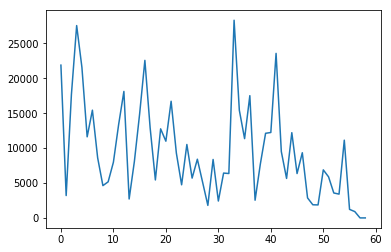

In [106]:
#SPLIT POINTS IN LAYERS
splitPoints_layers = np.zeros(len(layers))

channelIdx = 0
for layerIndx in range(0,len(layers)):
    nbrOfChannels = int(layers[idx].shape[3])
    splitPoints_layers[layerIndx] = np.average(splitPoints[channelIdx:(channelIdx+nbrOfChannels)])
    channelIdx +=nbrOfChannels
    print("Layer " + str(layerIndx) + " " + layer_names[layerIndx] + " split point: " + str(splitPoints_layers[layerIndx]))

plt.plot(splitPoints_layers)

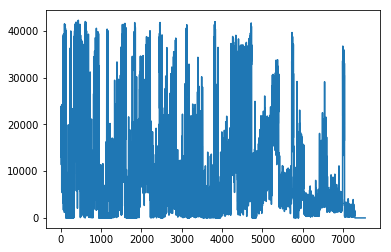

In [104]:
plt.plot(splitPoints)

In [15]:
#SHOW IMAGE

imageID = 2130
img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

image_names = os.listdir(img_dir)
image_names = sorted(image_names)

img_path = img_dir + image_names[imageID]

label = classNames[int(grountTruth[imageID])]
print("Image class:" + label)

im = Image.open(img_path)
im.show()



Image class:green snake


In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))
for idx in range(0,len(layers)):
    print('\n Feature layer: ' + str(layers[idx]) + ' nbr of channels: '+ str(feature_nums[idx]))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Number of layers 59
Total number of feature channels: 7548

 Feature layer: import/conv2d0_pre_relu/conv nbr of channels: 64

 Feature layer: import/conv2d1_pre_relu/conv nbr of channels: 64

 Feature layer: import/conv2d2_pre_relu/conv nbr of channels: 192

 Feature layer: import/mixed3a_1x1_pre_relu/conv nbr of channels: 64

 Feature layer: import/mixed3a_3x3_bottleneck_pre_relu/conv nbr of channels: 96

 Feature layer: import/mixed3a_3x3_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3a_5x5_bottleneck_pre_relu/conv nbr of channels: 16

 Feature layer: import/mixed3a_5x5_pre_relu/conv nbr of channels: 32

 Feature layer: import/mixed3a_pool_reduce_pre_relu/conv nbr of channels: 32

 Feature layer: import/mixed3b_1x1_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3b_3x3_bottleneck_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3b_3x3_pre_relu/conv nbr of channels: 192

 Feature layer: import/mixed3b_5x5_bottleneck_pre_relu/conv nbr of

In [105]:
layer_indexes[53]

array([6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614,
       6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625,
       6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636,
       6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647,
       6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658,
       6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669,
       6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680,
       6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691,
       6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702,
       6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713,
       6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724,
       6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735,
       6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746,
       6747, 6748, 6749, 6750, 6751, 6752, 6753, 67

In [106]:
#CHANNEL VISUALIZATION

# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.

layer = 'mixed5b_3x3_pre_relu' #layer[53] , channel 6845=245 , 6604=0
channel = 0 # picking some feature channel to visualize

#from the example:
#layer = 'mixed4d_3x3_bottleneck_pre_relu'
#channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

### VISUALIZATION TRANSFORMATIONS ###

def jitter(in_image):
    jitter = randrange(1,17)
    


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        print("Iteration " + str(i+1) + "/" + str(iter_n),end='\r')
        g, score = sess.run([t_grad, t_score], {t_input:img})
        
        #print(str(g))
        #input("next")
        
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    #showarray(visstd(img))
    return img

img = render_naive(T(layer)[:,:,:,channel],iter_n=10)

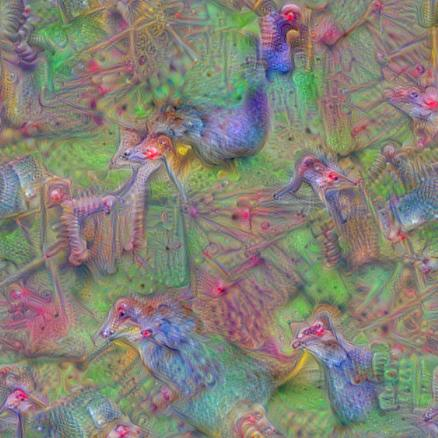

In [107]:
#CHANNEL VISUALIZATION - Laplacian Pyramid Gradient Normalization

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

#------------------------------------------------------------------------------------------------------------------#


def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))


#------------------------------------------------------------------------------------------------------------------#


k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]
    

def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel],iter_n=100)

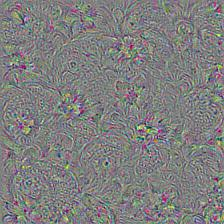

In [90]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
showarray(visstd(img))